## Notebook for Interpretability 
Trying to understand what aspects of the input text the model is looking at for making the prediction.  

In [12]:
# Import libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from peft import PeftModel
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Task 1: Load Predictions DataFrame

In [3]:
predictions_path = '/home/mohit/projects/precog_task/task_2/tier_c/gtest_distilbert_predictions.csv'
df = pd.read_csv(predictions_path)

print("Columns:", df.columns.tolist())
print(f"\nTotal samples: {len(df)}")
print(f"\nLabel distributions:")
print(f"Original labels (3-class): {df['original_label'].value_counts().sort_index().to_dict()}")
print(f"Binary labels: {df['binary_label'].value_counts().sort_index().to_dict()}")
print(f"Predicted labels: {df['predicted_label'].value_counts().sort_index().to_dict()}")

df.head()

Columns: ['text', 'original_label', 'binary_label', 'predicted_label', 'probability_ai', 'original_class', 'predicted_class']

Total samples: 174

Label distributions:
Original labels (3-class): {0: 60, 1: 60, 2: 54}
Binary labels: {0: 60, 1: 114}
Predicted labels: {0: 53, 1: 121}


,text,original_label,binary_label,predicted_label,probability_ai,original_class,predicted_class
0,We naturally gravitate towards information and...,2,1,1,0.999993,AI Mimic,AI
1,"And then you move out of that initial, super-i...",2,1,1,0.959548,AI Mimic,AI
2,When were voting for president were not techni...,0,0,0,0.001322,Human,Human
3,"And then, as we get older, these foundational ...",2,1,1,0.994269,AI Mimic,AI
4,It’s like putting money in a mental bank accou...,2,1,1,0.999309,AI Mimic,AI


Instead of comparing fields and doing operations all the time, lets have more accessible fields like 
- Correct
- Text len (maybe there is a trend in this?)
- Word count

In [26]:
df['correct'] = df['binary_label'] == df['predicted_label']
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# show predictions 
print("Prediction Accuracy Summary:")
print(f"  Correct: {df['correct'].sum()} ({df['correct'].mean()*100:.2f}%)")
print(f"  Incorrect: {(~df['correct']).sum()} ({(~df['correct']).mean()*100:.2f}%)")

# Show misclassifications
misclassified = df[~df['correct']]
print(f"\nMisclassification breakdown:")
print(f"  Human → AI (False Positives): {((df['binary_label']==0) & (df['predicted_label']==1)).sum()}")
print(f"  AI → Human (False Negatives): {((df['binary_label']==1) & (df['predicted_label']==0)).sum()}")

df.head()

Prediction Accuracy Summary:
  Correct: 157 (90.23%)
  Incorrect: 17 (9.77%)

Misclassification breakdown:
  Human → AI (False Positives): 12
  AI → Human (False Negatives): 5


,text,original_label,binary_label,predicted_label,probability_ai,original_class,predicted_class,correct,text_length,word_count
0,We naturally gravitate towards information and...,2,1,1,0.999993,AI Mimic,AI,True,1362,177
1,"And then you move out of that initial, super-i...",2,1,1,0.959548,AI Mimic,AI,True,1185,197
2,When were voting for president were not techni...,0,0,0,0.001322,Human,Human,True,2568,426
3,"And then, as we get older, these foundational ...",2,1,1,0.994269,AI Mimic,AI,True,1210,194
4,It’s like putting money in a mental bank accou...,2,1,1,0.999309,AI Mimic,AI,True,1138,182


Load the human AI pair dataset (Has human essays and AI essays on the same topics) 

In [5]:
from datasets import load_dataset
ds = load_dataset("gsingh1-py/train")
print(f"\nDataset splits: {list(ds.keys())}")

/home/mohit/projects/precog_task/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.



Dataset splits: ['train']


In [ ]:
pair_ds = ds['train']

# Convert to pandas DataFrame, keeping only specified fields and first 200 rows
df_pair = pair_ds.to_pandas()
df_pair = df_pair[['Human_story', 'mistral-7B']]

df_pair.head()

## Task 2: Load the Fine-Tuned Model

In [15]:
# Load tokenizer and model
base_model_name = 'distilbert-base-uncased'
lora_model_path = '/home/mohit/projects/precog_task/task_2/tier_c/distilbert_lora_model'

print("Loading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(base_model_name)

print("Loading base model...")
base_model = DistilBertForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=2,
    output_attentions=True  # plan is to later look at attention values also 
)

print("Loading LoRA weights...")
model = PeftModel.from_pretrained(base_model, lora_model_path)
model = model.to(device)
model.eval()

print(f"Model loaded successfully!")

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 40c355ad-401d-4aa0-b876-5eedb0ce036b)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].


Loading tokenizer...


Loading base model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading LoRA weights...
Model loaded successfully!


- Learnt what Saliency maps are and the math+intuition behind that from the video 
https://www.youtube.com/watch?v=RFE6xdfJvag&t=122s

- Talk about why we used IG 

- Proper Integrated Gradients implementation with:
    1. PAD token baseline (represents "no meaningful input")
    2. Zero attention mask baseline (tokens are masked out)
    3. Convergence delta checking
    4. Proper normalization

In [5]:
from captum.attr import LayerIntegratedGradients
import gc


def custom_forward(input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.logits

# Set up Layer Integrated Gradients on embedding layer
embedding_layer = model.base_model.model.distilbert.embeddings
lig = LayerIntegratedGradients(custom_forward, embedding_layer)

def interpret_text_captum(text, target_class=None, n_steps=50, max_length=256):
    # Tokenize
    encoding = tokenizer(
        text, 
        return_tensors='pt', 
        max_length=max_length, 
        truncation=True, 
        padding='max_length'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get prediction first (no gradients needed)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()
    
    if target_class is None:
        target_class = pred_class
    
    # Create baseline: PAD tokens with zero attention mask
    baseline_ids = torch.full_like(input_ids, tokenizer.pad_token_id).to(device)
    baseline_attention_mask = torch.zeros_like(attention_mask).to(device)
    
    attributions, delta = lig.attribute(
        inputs=input_ids,
        baselines=baseline_ids,
        target=target_class,
        additional_forward_args=(attention_mask,),
        return_convergence_delta=True,
        n_steps=n_steps,
        internal_batch_size=1  # Process one step at a time to save memory
    )
    
    #check during training to see the delta values 
    delta_val = delta.item()
    if abs(delta_val) > 0.1:
        print(f"Warning: Large convergence delta ({delta_val:.4f}) - results may be imprecise")
    
    # Sum attributions across embedding dimension to get token-level scores
    # Shape: (batch, seq_len, embed_dim) -> (batch, seq_len)
    token_attributions = attributions.sum(dim=-1).squeeze(0)
    
    # Normalize by L2 norm for better interpretation
    norm = torch.norm(token_attributions)
    if norm > 0:
        token_attributions = token_attributions / norm
    
    # Convert to numpy
    token_attributions = token_attributions.cpu().detach().numpy()
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    
    # Cleanup
    del input_ids, attention_mask, outputs, attributions
    del baseline_ids, baseline_attention_mask
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return tokens, token_attributions, pred_class, confidence

In [21]:
def visualize_attributions(tokens, attributions, pred_class, confidence, true_label=None, max_tokens=512):
    """
    Create a colored HTML visualization of token attributions.
    Green = pushes towards Human (class 0)
    Red = pushes towards AI (class 1)
    """
    # Take only first max_tokens (excluding [CLS] and [SEP] at ends)
    tokens = tokens[1:max_tokens+1]  # Skip [CLS]
    attributions = attributions[1:max_tokens+1]
    
    # Remove [SEP] and [PAD] tokens
    filtered = [(t, a) for t, a in zip(tokens, attributions) if t not in ['[SEP]', '[PAD]']]
    if filtered:
        tokens, attributions = zip(*filtered)
        tokens, attributions = list(tokens), list(attributions)
    
    # Normalize attributions for coloring
    max_attr = max(abs(min(attributions)), abs(max(attributions))) if attributions else 1
    if max_attr == 0:
        max_attr = 1
    
    # Build HTML
    html = f"<div style='font-family: monospace; line-height: 1.8; padding: 10px;'>"
    html += f"<b>Prediction:</b> {'AI' if pred_class == 1 else 'Human'} (confidence: {confidence:.4f})<br>"
    if true_label is not None:
        html += f"<b>True Label:</b> {'AI' if true_label == 1 else 'Human'}<br>"
    html += "<br>"
    
    for token, attr in zip(tokens, attributions):
        # Normalize attribution to [-1, 1]
        norm_attr = attr / max_attr
        
        # Color: positive (red/AI) vs negative (green/Human)
        if norm_attr > 0:
            # Red for AI-leaning tokens
            intensity = min(abs(norm_attr), 1)
            color = f"rgba(255, 0, 0, {intensity * 0.7})"
        else:
            # Green for Human-leaning tokens
            intensity = min(abs(norm_attr), 1)
            color = f"rgba(0, 255, 0, {intensity * 0.7})"
        
        # Handle subword tokens
        display_token = token.replace('##', '')
        if token.startswith('##'):
            html += f"<span style='background-color: {color};'>{display_token}</span>"
        else:
            html += f" <span style='background-color: {color};'>{display_token}</span>"
    
    html += "</div>"
    html += "<p><small>🔴 Red = pushes towards AI | 🟢 Green = pushes towards Human</small></p>"
    
    return HTML(html)

print("✓ Visualization function defined")

✓ Visualization function defined


For right predicted human sample, lets see the structure of the pro-human tokens and anti-human ones 

In [12]:
human_correct = df[(df['binary_label'] == 0) & (df['correct'])].iloc[0]
print(f"Text (first 300 chars): {human_correct['text'][:300]}...")
print()

tokens, attrs, pred, conf = interpret_text_captum(human_correct['text'])
display(visualize_attributions(tokens, attrs, pred, conf, true_label=0))

Text (first 300 chars): When were voting for president were not technically voting for the president in fact we are voting for the slate of electors. The electors can be anyone without a public holding office. Electoral college process is not a good process for presidency. While a president can get the majority of the popu...



#### Typo like "were" here pushed the model's output farther from a human? Thats an interesting observation.
#### Lets try with AI text predicted to be AI now

In [19]:
# 2. Correctly classified AI text
ai_correct = df[(df['binary_label'] == 1) & (df['correct'])].iloc[42]  # random index i picked cuz others were AI mimic
print(f"Original class: {ai_correct['original_class']}")
print(f"Text (first 300 chars): {ai_correct['text'][:300]}...")
print()

tokens, attrs, pred, conf = interpret_text_captum(ai_correct['text'])
display(visualize_attributions(tokens, attrs, pred, conf, true_label=1))

Original class: AI
Text (first 300 chars): "The Nissan Patrol, a formidable player in the realm of off-road vehicles, stands as a symbol of rugged durability and power. First introduced in the 1950s, the Patrol was Nissan's answer to the growing demand for a robust and capable all-terrain vehicle. Over the decades, it has evolved from a basi...



### Analyze Misclassified Examples

In [22]:
# 3. Human text misclassified as AI (False Positive)
human_as_ai = df[(df['binary_label'] == 0) & (df['predicted_label'] == 1)]
sample = human_as_ai.iloc[0]
print(f"Text (first 500 chars): {sample['text'][:500]}...")
print()
    
tokens, attrs, pred, conf = interpret_text_captum(sample['text'])
display(visualize_attributions(tokens, attrs, pred, conf, true_label=0))

Text (first 500 chars): Think about how many times a week we get in a car to drive somewhere. I know I drive to school, to lacrosse practice, and to spend time with friends on a weekly basis. Some people may claim that driving is a positive aspect of our culture because it allows us to get from one place to another and accomplish tasks in a timely fashion, but driving in excess has some serious consequences. Although some may argue that it is impossible to completely cut out an action that is essential to our daily liv...



Now the other way of misclassification 

In [23]:
# 4. AI text misclassified as Human (False Negative)
ai_as_human = df[(df['binary_label'] == 1) & (df['predicted_label'] == 0)]
if len(ai_as_human) > 0:
    sample = ai_as_human.iloc[0]
    print(f"Original class: {sample['original_class']}")
    print(f"Text (first 500 chars): {sample['text'][:500]}...")
    print()
    
    tokens, attrs, pred, conf = interpret_text_captum(sample['text'])
    display(visualize_attributions(tokens, attrs, pred, conf, true_label=1))
else:
    print("No AI→Human misclassifications found")

Original class: AI
Text (first 500 chars): I strongly believe that the Electoral College should remain the way it is or, better yet, that we should elect the president by popular vote. This is due to the fact that the Electoral College does not accurately reflect the will of the people. For example, in the 2016 presidential election, an estimated two million more people voted for Hillary Clinton than for Donald Trump however, Trump won the Electoral College vote, 304 to 232. This means that a candidate can win a majority of the Electoral...



## Task 2B: Aggregate Token Importance Analysis

Analyze which tokens/words are most frequently important across many samples.

Going by samples and highlighting worked for checking any patterns but not efficient. Lets analyse a few samples and look at the top attributed tokens.

In [6]:
# Aggregate analysis across all correctly classified samples
def collect_influential_tokens(df_subset, label_name, target_class, n_steps=50):
    """
    Collect influential tokens across multiple samples using Integrated Gradients.
    
    Args:
        df_subset: DataFrame subset to analyze
        label_name: Label for progress tracking
        target_class: 0 for Human, 1 for AI
        n_steps: Number of IG steps (higher = more accurate)
    
    Returns:
        all_positive_tokens: List of (token, attribution) for tokens pushing toward target
        all_negative_tokens: List of (token, attribution) for tokens pushing away from target
    """
    all_positive_tokens = []  # Tokens pushing toward the predicted class
    all_negative_tokens = []  # Tokens pushing away from the predicted class
    
    failed_samples = 0
    large_deltas = 0
    
    for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Analyzing {label_name}"):
        try:
            # Run Integrated Gradients with specified n_steps
            tokens, attributions, pred_class, confidence = interpret_text_captum(
                row['text'], 
                target_class=target_class,
                n_steps=n_steps
            )
            
            for token, attr in zip(tokens, attributions):
                # Skip special tokens
                if token in ['[CLS]', '[SEP]', '[PAD]']:
                    continue
                
                # Clean up subword tokens
                clean_token = token.replace('##', '').lower()
                if len(clean_token) <= 1:  # Skip single characters
                    continue
                    
                if target_class == 1:  # AI class
                    # Positive attribution means pushing toward AI
                    if attr > 0:
                        all_positive_tokens.append((clean_token, float(attr)))
                    else:
                        all_negative_tokens.append((clean_token, abs(float(attr))))
                else:  # Human class (0)
                    # Negative attribution means pushing toward Human (away from AI)
                    if attr < 0:
                        all_positive_tokens.append((clean_token, abs(float(attr))))
                    else:
                        all_negative_tokens.append((clean_token, float(attr)))
                        
        except Exception as e:
            print(f"Error on sample {idx}: {str(e)[:100]}")
            failed_samples += 1
            continue
    
    if failed_samples > 0:
        print(f"\n {failed_samples} samples failed to process")
    
    return all_positive_tokens, all_negative_tokens

In [ ]:
# Full Integrated Gradients analysis - ALL correctly classified samples
import gc

# Get correctly classified samples
human_correct_all = df[(df['binary_label'] == 0) & (df['predicted_label'] == 0)]
ai_correct_all = df[(df['binary_label'] == 1) & (df['predicted_label'] == 1)]

# Use ALL samples for comprehensive analysis
n_samples_human = len(human_correct_all)
n_samples_ai = len(ai_correct_all)
n_steps = 50    # Standard IG steps for accuracy

print(f"Configuration:")
print(f"  - Human samples: {n_samples_human} (ALL correctly classified)")
print(f"  - AI samples: {n_samples_ai} (ALL correctly classified)")
print(f"  - Integration steps: {n_steps}")
print(f"  - Baseline: PAD tokens + zero attention mask")
print(f"  - Expected time: ~{(n_samples_human + n_samples_ai) * 5 / 60:.1f} minutes")
print("=" * 80)

# Analyze ALL Human samples
print(f"\n Analyzing {n_samples_human} Human samples...")
gc.collect()
human_pos_tokens, human_neg_tokens = collect_influential_tokens(
    human_correct_all, 
    "Human", 
    target_class=0,
    n_steps=n_steps
)

# Analyze ALL AI samples
print(f"\nAnalyzing {n_samples_ai} AI samples...")
gc.collect()
ai_pos_tokens, ai_neg_tokens = collect_influential_tokens(
    ai_correct_all, 
    "AI", 
    target_class=1,
    n_steps=n_steps
)

# Summary
print(f"Results collected:")
print(f"  Human samples analyzed: {n_samples_human}")
print(f"  Human-indicative tokens: {len(human_pos_tokens)} (pushing toward Human)")
print(f"  Human-divergent tokens: {len(human_neg_tokens)} (pushing away)")
print(f"")
print(f"  AI samples analyzed: {n_samples_ai}")
print(f"  AI-indicative tokens: {len(ai_pos_tokens)} (pushing toward AI)")
print(f"  AI-divergent tokens: {len(ai_neg_tokens)} (pushing away)")
print(f"\nToken data ready for aggregation and visualization.")
print(f"Total tokens collected: {len(human_pos_tokens) + len(human_neg_tokens) + len(ai_pos_tokens) + len(ai_neg_tokens)}")

mention that compute was heavy so did the compute on colab and got the pickle file here 

In [7]:
import pickle 

with open("./ig_token_attributions.pkl","rb") as file:
    results = pickle.load(file)

print(results)
human_pos_tokens = results['human_pos']
human_neg_tokens = results['human_neg']
ai_pos_tokens = results['ai_pos']
ai_neg_tokens = results['ai_neg']

{'human_pos': [('technically', 0.031772810965776443), ('in', 0.02888421155512333), ('slate', 0.01250726729631424), ('college', 0.0005783572560176253), ('not', 0.03031100705265999), ('for', 0.0042868382297456264), ('college', 0.005808032583445311), ('technically', 0.04297011345624924), ('the', 0.01610507071018219), ('should', 0.012208166532218456), ('into', 0.007989180274307728), ('def', 0.03137628734111786), ('people', 0.0007845962536521256), ('efe', 0.01799127086997032), ('defenses', 0.044410932809114456), ('plume', 0.04313743859529495), ('it', 0.04654921591281891), ('1960', 0.01425359956920147), ('segregation', 0.15088872611522675), ('louisiana', 0.07644648849964142), ('legislature', 0.10489501059055328), ('hon', 0.016785601153969765), ('kennedy', 0.003011214779689908), ('so', 0.05566887930035591), ('that', 0.0629597082734108), ('popular', 0.015319657512009144), ('kennedy', 0.018562249839305878), ('the', 0.007608696818351746), ('gone', 0.018922289833426476), ('too', 0.055384404957294

Show the 

In [8]:
# Aggregate and rank tokens by total attribution score
def aggregate_token_scores(token_list):
    """Aggregate scores for the same token across samples."""
    token_scores = {}
    token_counts = {}
    
    for token, score in token_list:
        token_lower = token.lower().replace('##', '')  # Normalize subword tokens
        if token_lower not in token_scores:
            token_scores[token_lower] = 0
            token_counts[token_lower] = 0
        token_scores[token_lower] += score
        token_counts[token_lower] += 1
    
    # Calculate average score
    token_avg = {t: token_scores[t] / token_counts[t] for t in token_scores}
    
    # Sort by total score
    sorted_by_total = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_by_avg = sorted(token_avg.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_by_total, sorted_by_avg, token_counts
    
#pro human or anti AI is the same thing 
pro_human_tok = human_pos_tokens + ai_neg_tokens
pro_ai_tok = human_neg_tokens + ai_pos_tokens    
human_total, human_avg, human_counts = aggregate_token_scores(pro_human_tok)
print("\nTop 20 tokens (by total attribution):")
for token, score in human_total[:20]:
    print(f"  '{token}': total={score:.4f}, count={human_counts[token]}, avg={score/human_counts[token]:.4f}")

print("\nTop 20 tokens (by average attribution):")
# Filter to tokens that appear at least 3 times
human_avg_filtered = [(t, s) for t, s in human_avg if human_counts[t] >= 3]
for token, score in human_avg_filtered[:20]:
    print(f"  '{token}': avg={score:.4f}, count={human_counts[token]}")


Top 20 tokens (by total attribution):
  'the': total=4.0766, count=246, avg=0.0166
  'it': total=2.8546, count=117, avg=0.0244
  'we': total=1.8194, count=89, avg=0.0204
  'of': total=1.6304, count=124, avg=0.0131
  'and': total=1.5351, count=98, avg=0.0157
  'in': total=1.4075, count=107, avg=0.0132
  'to': total=1.3778, count=88, avg=0.0157
  'or': total=1.1447, count=45, avg=0.0254
  'is': total=1.1363, count=68, avg=0.0167
  'but': total=1.1226, count=25, avg=0.0449
  'not': total=1.0645, count=36, avg=0.0296
  'college': total=0.9294, count=50, avg=0.0186
  'so': total=0.8950, count=23, avg=0.0389
  'chess': total=0.8355, count=12, avg=0.0696
  'you': total=0.8112, count=52, avg=0.0156
  'as': total=0.8007, count=45, avg=0.0178
  'that': total=0.7883, count=56, avg=0.0141
  'our': total=0.7554, count=44, avg=0.0172
  'are': total=0.7398, count=43, avg=0.0172
  'all': total=0.7371, count=22, avg=0.0335

Top 20 tokens (by average attribution):
  'sner': avg=0.1011, count=3
  'outda

Most AI indicative tokens as well

In [9]:
# Analyze AI-indicative tokens

ai_total, ai_avg, ai_counts = aggregate_token_scores(pro_ai_tok)
print("\nTop 20 tokens (by total attribution):")
for token, score in ai_total[:20]:
    print(f"  '{token}': total={score:.4f}, count={ai_counts[token]}, avg={score/ai_counts[token]:.4f}")

print("\nTop 20 tokens (by average attribution):")
# Filter to tokens that appear at least 3 times
ai_avg_filtered = [(t, s) for t, s in ai_avg if ai_counts[t] >= 3]
for token, score in ai_avg_filtered[:20]:
    print(f"  '{token}': avg={score:.4f}, count={ai_counts[token]}")


Top 20 tokens (by total attribution):
  'the': total=36.4509, count=1352, avg=0.0270
  'and': total=21.1915, count=804, avg=0.0264
  'of': total=18.8140, count=818, avg=0.0230
  'to': total=14.0555, count=597, avg=0.0235
  'in': total=9.0035, count=401, avg=0.0225
  'is': total=8.5180, count=261, avg=0.0326
  'that': total=8.1190, count=257, avg=0.0316
  'are': total=6.8539, count=159, avg=0.0431
  'for': total=6.0349, count=288, avg=0.0210
  'it': total=5.9938, count=182, avg=0.0329
  'you': total=5.9595, count=110, avg=0.0542
  'we': total=5.1940, count=96, avg=0.0541
  'this': total=5.0270, count=147, avg=0.0342
  'or': total=4.3569, count=168, avg=0.0259
  'they': total=4.2753, count=98, avg=0.0436
  'our': total=4.0224, count=140, avg=0.0287
  'vote': total=3.7658, count=79, avg=0.0477
  'have': total=3.7006, count=92, avg=0.0402
  'there': total=3.5872, count=62, avg=0.0579
  'president': total=3.2209, count=66, avg=0.0488

Top 20 tokens (by average attribution):
  'says': avg=0

Plot these as a sideways histogram

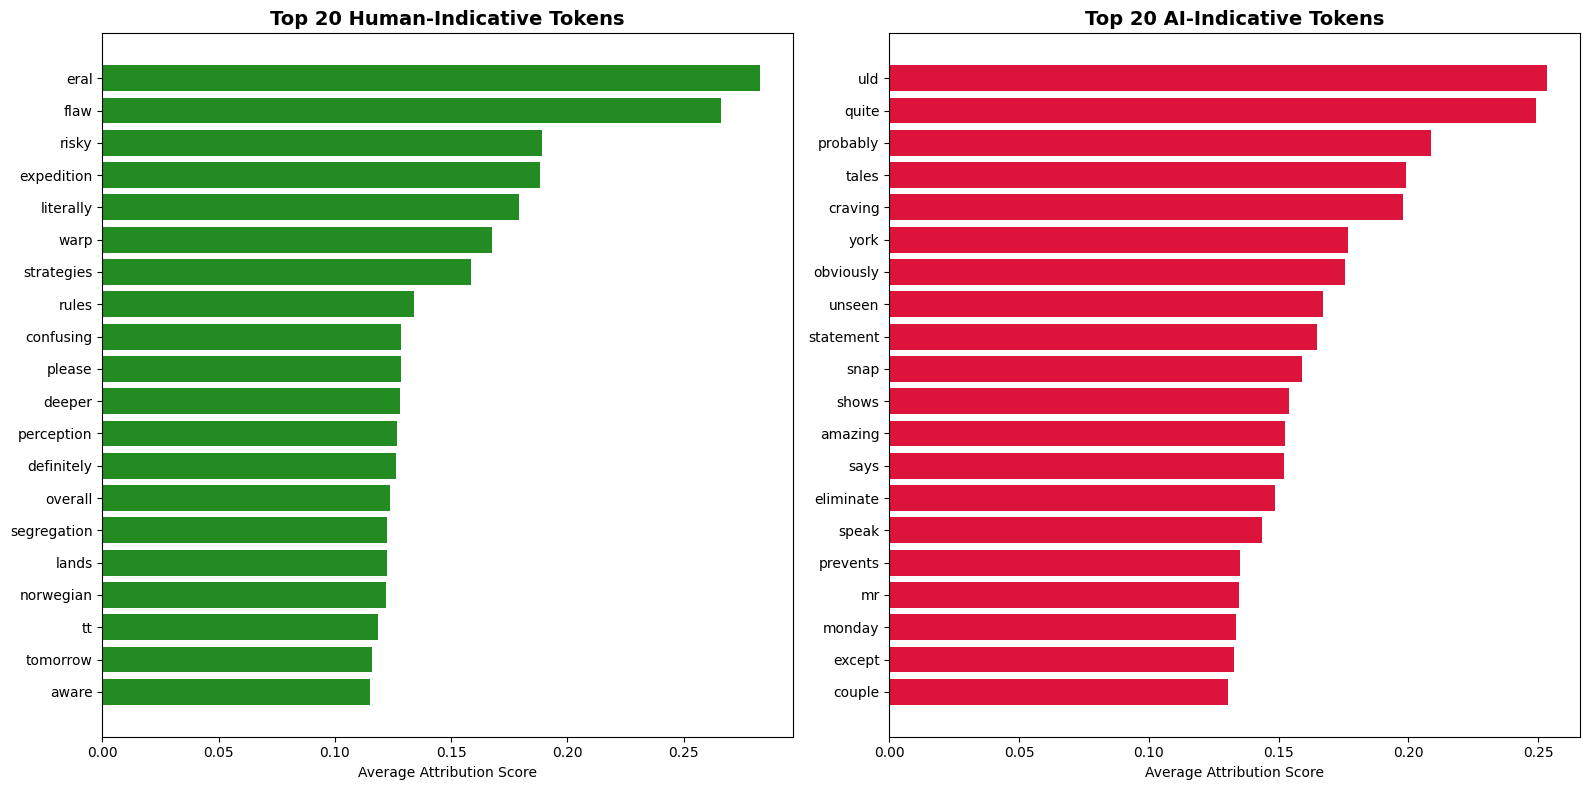

✓ Visualization saved to 'token_comparison.png'


In [10]:
# Create visualization comparing Human vs AI indicative tokens (by AVERAGE)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Human indicative tokens - use AVERAGE scores
human_top_20 = human_avg[:20]
tokens_h = [t for t, _ in human_top_20]
scores_h = [s for _, s in human_top_20]
axes[0].barh(range(len(tokens_h)), scores_h, color='forestgreen')
axes[0].set_yticks(range(len(tokens_h)))
axes[0].set_yticklabels(tokens_h, fontsize=10)
axes[0].invert_yaxis()
axes[0].set_xlabel('Average Attribution Score')
axes[0].set_title('Top 20 Human-Indicative Tokens', fontsize=14, fontweight='bold')

# AI indicative tokens - use AVERAGE scores
ai_top_20 = ai_avg[:20]
tokens_ai = [t for t, _ in ai_top_20]
scores_ai = [s for _, s in ai_top_20]
axes[1].barh(range(len(tokens_ai)), scores_ai, color='crimson')
axes[1].set_yticks(range(len(tokens_ai)))
axes[1].set_yticklabels(tokens_ai, fontsize=10)
axes[1].invert_yaxis()
axes[1].set_xlabel('Average Attribution Score')
axes[1].set_title('Top 20 AI-Indicative Tokens', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('token_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to 'token_comparison.png'")

- There are no specific semantic related words here, most are general words. 
- One thing i see AI has a few more abstract words here. Ill take that into consideration going forward
- Lets really check if its looking at the rhytm of the sequence

### Experiment 1 Word Jumbling 

Trying to test if the model really looks at style? During jumbling we destory the sentence structure so technically model's accuracy should fall.  

In [ ]:
import random
import numpy as np

def jumble_text(text, seed=42):
    """Randomly shuffle all words in the text while preserving word set."""
    words = text.split()
    random.seed(seed)
    random.shuffle(words)
    return ' '.join(words)

def predict_single(text):
    """Get prediction and confidence for a single text."""
    encoding = tokenizer(
        text, 
        return_tensors='pt', 
        max_length=512, 
        truncation=True, 
        padding=True
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()
    
    return pred_class, confidence, probs[0].cpu().numpy()

df_test = df.copy()
df_test['jumbled_text'] = df_test['text'].apply(jumble_text)

# Get predictions on original and jumbled text
original_preds = []
original_confs = []
jumbled_preds = []
jumbled_confs = []

print("Running predictions on original and jumbled texts...")
for idx, row in tqdm(df_test.iterrows(), total=len(df_test)):
    # Original
    pred, conf, _ = predict_single(row['text'])
    original_preds.append(pred)
    original_confs.append(conf)
    
    # Jumbled
    pred_j, conf_j, _ = predict_single(row['jumbled_text'])
    jumbled_preds.append(pred_j)
    jumbled_confs.append(conf_j)

df_test['original_pred'] = original_preds
df_test['original_conf'] = original_confs
df_test['jumbled_pred'] = jumbled_preds
df_test['jumbled_conf'] = jumbled_confs

# Calculate accuracies
original_acc = (df_test['original_pred'] == df_test['binary_label']).mean()
jumbled_acc = (df_test['jumbled_pred'] == df_test['binary_label']).mean()

print("\n" + "=" * 90)
print("RESULTS")
print("=" * 90)
print(f"\n ACCURACY COMPARISON:")
print(f"   Original text accuracy:  {original_acc*100:.2f}%")
print(f"   Jumbled text accuracy:   {jumbled_acc*100:.2f}%")
print(f"   Accuracy DROP:           {(original_acc - jumbled_acc)*100:.2f} percentage points")

print(f"\nCONFIDENCE COMPARISON:")
print(f"   Original mean confidence: {np.mean(original_confs):.4f}")
print(f"   Jumbled mean confidence:  {np.mean(jumbled_confs):.4f}")
print(f"   Confidence DROP:          {np.mean(original_confs) - np.mean(jumbled_confs):.4f}")

# Breakdown by class
print(f"\nBREAKDOWN BY TRUE CLASS:")
human_mask = df_test['binary_label'] == 0
ai_mask = df_test['binary_label'] == 1

human_orig_acc = (df_test.loc[human_mask, 'original_pred'] == 0).mean()
human_jump_acc = (df_test.loc[human_mask, 'jumbled_pred'] == 0).mean()
ai_orig_acc = (df_test.loc[ai_mask, 'original_pred'] == 1).mean()
ai_jump_acc = (df_test.loc[ai_mask, 'jumbled_pred'] == 1).mean()

print(f"   Human texts - Original: {human_orig_acc*100:.1f}% → Jumbled: {human_jump_acc*100:.1f}% (Δ = {(human_orig_acc-human_jump_acc)*100:+.1f}%)")
print(f"   AI texts    - Original: {ai_orig_acc*100:.1f}% → Jumbled: {ai_jump_acc*100:.1f}% (Δ = {(ai_orig_acc-ai_jump_acc)*100:+.1f}%)")

Running predictions on original and jumbled texts...


  0%|          | 0/174 [00:00<?, ?it/s]

100%|██████████| 174/174 [02:22<00:00,  1.22it/s]


RESULTS

📊 ACCURACY COMPARISON:
   Original text accuracy:  90.23%
   Jumbled text accuracy:   87.93%
   Accuracy DROP:           2.30 percentage points

📊 CONFIDENCE COMPARISON:
   Original mean confidence: 0.9707
   Jumbled mean confidence:  0.9647
   Confidence DROP:          0.0060

📊 BREAKDOWN BY TRUE CLASS:
   Human texts - Original: 80.0% → Jumbled: 100.0% (Δ = -20.0%)
   AI texts    - Original: 95.6% → Jumbled: 81.6% (Δ = +14.0%)


Confidence didnt drop at all? 
- Accuracy of humans increased and AI decreased -> meaning the model predicts more texts to be human now. (already ones+some AI as well) 
- But accuracy doesnt plummet completely, still has a respectable 87% so its not heavily reliant on rhythm

### Experiment 2: Random Gibberish Test

Testing if model simply uses "incoherence = human" heuristic

In [12]:
# Get English words
import nltk
try:
    from nltk.corpus import words
    english_words = words.words()
except:
    nltk.download('words', quiet=True)
    from nltk.corpus import words
    english_words = words.words()

# Filter to reasonable words (3-12 characters, lowercase only)
vocab = [w.lower() for w in english_words if 3 <= len(w) <= 12 and w.isalpha()]
print(f"Vocabulary: {len(vocab):,} English words")

Vocabulary: 199,071 English words


In [13]:
# Create vocab_2 from testing set words
all_words = []
for text in df['text']:
    words_in_text = text.lower().split()
    all_words.extend(words_in_text)

# Filter to reasonable words (3-12 characters, alphabetic only)
vocab_2 = list(set([w for w in all_words if 3 <= len(w) <= 12 and w.isalpha()]))

print(f"vocab_2 (from testing set): {len(vocab_2):,} unique words")
print(f"Sample words: {vocab_2[:10]}")

vocab_2 (from testing set): 4,988 unique words
Sample words: ['versus', 'trying', 'forty', 'futuristic', 'interests', 'supossed', 'keys', 'written', 'behind', 'absence']


In [15]:
def generate_random_text(vocab, n_words=530, seed=None):
    """Generate completely random text from vocabulary."""
    if seed is not None:
        random.seed(seed)
    return ' '.join(random.choices(vocab, k=n_words))

In [16]:
# Generate random texts from BOTH vocabularies
n_samples = 20


# vocab (NLTK English dictionary)
random_texts_nltk = [generate_random_text(vocab, n_words=530, seed=i*42) for i in range(n_samples)]

# vocab_2 (testing set vocabulary)
random_texts_testset = [generate_random_text(vocab_2, n_words=530, seed=i*42) for i in range(n_samples)]

# Show examples
print("Example from NLTK vocab:")
print(random_texts_nltk[0][:150] + "...")
print("\nExample from Testing Set vocab:")
print(random_texts_testset[0][:150] + "...")

Example from NLTK vocab:
tentaculites sheepless isodrome ektene montiform infidelism sour flabbergast mandrel pagehood unemulous mithridatic euplexoptera shaftless phytomer du...

Example from Testing Set vocab:
reframing gonna physical heat engine steer district mainly camapign mixing electora difficult disposable complexity sell adult battlefield offers limi...


In [17]:
# Classify random texts from BOTH vocabularies
results_nltk = []
results_testset = []

print("Classifying NLTK vocab random texts...")
for i, text in enumerate(random_texts_nltk):
    pred, conf, probs = predict_single(text)
    results_nltk.append({
        'text': text,
        'pred': pred,
        'conf': conf,
        'p_ai': probs[1]
    })

print("Classifying Testing Set vocab random texts...")
for i, text in enumerate(random_texts_testset):
    pred, conf, probs = predict_single(text)
    results_testset.append({
        'text': text,
        'pred': pred,
        'conf': conf,
        'p_ai': probs[1]
    })

# Summary for NLTK vocab
n_human_nltk = sum(1 for r in results_nltk if r['pred'] == 0)
n_ai_nltk = sum(1 for r in results_nltk if r['pred'] == 1)
mean_p_ai_nltk = np.mean([r['p_ai'] for r in results_nltk])

# Summary for Testing Set vocab
n_human_testset = sum(1 for r in results_testset if r['pred'] == 0)
n_ai_testset = sum(1 for r in results_testset if r['pred'] == 1)
mean_p_ai_testset = np.mean([r['p_ai'] for r in results_testset])

print(f"\n{'='*60}")
print(f"NLTK Vocab Random Gibberish (n={n_samples}):")
print(f"  Human: {n_human_nltk} ({n_human_nltk/n_samples*100:.0f}%)")
print(f"  AI:    {n_ai_nltk} ({n_ai_nltk/n_samples*100:.0f}%)")
print(f"  Mean P(AI): {mean_p_ai_nltk:.3f}")

print(f"\nTesting Set Vocab Random Gibberish (n={n_samples}):")
print(f"  Human: {n_human_testset} ({n_human_testset/n_samples*100:.0f}%)")
print(f"  AI:    {n_ai_testset} ({n_ai_testset/n_samples*100:.0f}%)")
print(f"  Mean P(AI): {mean_p_ai_testset:.3f}")
print(f"{'='*60}")

Classifying NLTK vocab random texts...
Classifying Testing Set vocab random texts...
Classifying Testing Set vocab random texts...

NLTK Vocab Random Gibberish (n=20):
  Human: 0 (0%)
  AI:    20 (100%)
  Mean P(AI): 0.992

Testing Set Vocab Random Gibberish (n=20):
  Human: 0 (0%)
  AI:    20 (100%)
  Mean P(AI): 0.990

NLTK Vocab Random Gibberish (n=20):
  Human: 0 (0%)
  AI:    20 (100%)
  Mean P(AI): 0.992

Testing Set Vocab Random Gibberish (n=20):
  Human: 0 (0%)
  AI:    20 (100%)
  Mean P(AI): 0.990


- ok, so complete incoherence and chaos is also flagged AI.
- So maybe something very specific is considered as human  

### Experiment 3: N Gram Shuffle 

Trying to test what the boundary of randomness is which still does well on the testing set? 

In [18]:
def ngram_preserving_shuffle(text, n=2, seed=42):
    """
    Shuffle text while preserving N-gram structure.
    
    Method: Extract all contiguous N-grams (sliding window),
    then randomly permute their positions while keeping 
    words inside each N-gram intact.
    
    Args:
        text: Input text string
        n: N-gram size (2, 3, 4, 5)
        seed: Random seed for reproducibility
    
    Returns:
        Shuffled text with N-grams preserved
    """
    words = text.split()
    
    # If text is too short, return as-is
    if len(words) < n:
        return text
    
    # Extract all sliding N-grams
    ngrams = []
    for i in range(len(words) - n + 1):
        ngram = words[i:i+n]
        ngrams.append(ngram)
    
    # Shuffle the N-grams
    random.seed(seed)
    random.shuffle(ngrams)
    
    # Reconstruct text from shuffled N-grams
    # Use first word from each N-gram + last N-1 words from final N-gram
    result = []
    for i, ngram in enumerate(ngrams):
        if i == 0:
            # First N-gram: add all words
            result.extend(ngram)
        else:
            # Subsequent N-grams: only add the last word (to avoid repetition)
            result.append(ngram[-1])
    
    return ' '.join(result)

# Test the function
test_text = "the model shows quite a strong bias in text generation"
print("Original:", test_text)
print("N=2:", ngram_preserving_shuffle(test_text, n=2, seed=42))
print("N=3:", ngram_preserving_shuffle(test_text, n=3, seed=42))
print("N=4:", ngram_preserving_shuffle(test_text, n=4, seed=42))

Original: the model shows quite a strong bias in text generation
N=2: quite a in text strong generation quite bias model shows
N=3: quite a strong bias text generation a in shows quite
N=4: model shows quite a bias in strong generation quite text


In [19]:
# Run N-gram preserving shuffle experiment for N ∈ {2, 3, 4, 5}
ngram_sizes = [2, 3, 4, 5]

# Store results for each N
results_by_n = {}

for n in ngram_sizes:
    print(f"\n{'='*80}")
    print(f"Testing N={n}-gram Preserving Shuffle")
    print(f"{'='*80}")
    
    # Create shuffled versions
    df_ngram = df.copy()
    df_ngram[f'ngram_{n}_text'] = df_ngram['text'].apply(
        lambda x: ngram_preserving_shuffle(x, n=n, seed=42)
    )
    
    # Get predictions
    preds = []
    confs = []
    
    for idx, row in tqdm(df_ngram.iterrows(), total=len(df_ngram), desc=f"N={n}"):
        pred, conf, _ = predict_single(row[f'ngram_{n}_text'])
        preds.append(pred)
        confs.append(conf)
    
    df_ngram[f'ngram_{n}_pred'] = preds
    df_ngram[f'ngram_{n}_conf'] = confs
    
    # Calculate metrics
    accuracy = (df_ngram[f'ngram_{n}_pred'] == df_ngram['binary_label']).mean()
    mean_conf = np.mean(confs)
    
    # Breakdown by class
    human_mask = df_ngram['binary_label'] == 0
    ai_mask = df_ngram['binary_label'] == 1
    
    human_acc = (df_ngram.loc[human_mask, f'ngram_{n}_pred'] == 0).mean()
    ai_acc = (df_ngram.loc[ai_mask, f'ngram_{n}_pred'] == 1).mean()
    
    # Store results
    results_by_n[n] = {
        'accuracy': accuracy,
        'mean_confidence': mean_conf,
        'human_accuracy': human_acc,
        'ai_accuracy': ai_acc,
        'df': df_ngram
    }
    
    print(f"\nResults for N={n}:")
    print(f"  Overall Accuracy: {accuracy*100:.2f}%")
    print(f"  Mean Confidence: {mean_conf:.4f}")
    print(f"  Human Accuracy: {human_acc*100:.2f}%")
    print(f"  AI Accuracy: {ai_acc*100:.2f}%")

print(f"\n{'='*80}")
print("N-gram Shuffle Experiment Complete")
print(f"{'='*80}")


Testing N=2-gram Preserving Shuffle


N=2: 100%|██████████| 174/174 [01:10<00:00,  2.47it/s]



Results for N=2:
  Overall Accuracy: 86.78%
  Mean Confidence: 0.9599
  Human Accuracy: 100.00%
  AI Accuracy: 79.82%

Testing N=3-gram Preserving Shuffle


N=3: 100%|██████████| 174/174 [01:10<00:00,  2.46it/s]



Results for N=3:
  Overall Accuracy: 89.08%
  Mean Confidence: 0.9624
  Human Accuracy: 100.00%
  AI Accuracy: 83.33%

Testing N=4-gram Preserving Shuffle


N=4: 100%|██████████| 174/174 [01:05<00:00,  2.65it/s]



Results for N=4:
  Overall Accuracy: 86.21%
  Mean Confidence: 0.9640
  Human Accuracy: 100.00%
  AI Accuracy: 78.95%

Testing N=5-gram Preserving Shuffle


N=5: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s]


Results for N=5:
  Overall Accuracy: 88.51%
  Mean Confidence: 0.9589
  Human Accuracy: 100.00%
  AI Accuracy: 82.46%

N-gram Shuffle Experiment Complete


In [20]:
# Compare with baseline (original and fully jumbled)
comparison_data = {
    'Method': ['Original', 'Full Jumble (N=1)'],
    'Overall Acc': [original_acc * 100, jumbled_acc * 100],
    'Human Acc': [human_orig_acc * 100, human_jump_acc * 100],
    'AI Acc': [ai_orig_acc * 100, ai_jump_acc * 100]
}

# Add N-gram results
for n in ngram_sizes:
    comparison_data['Method'].append(f'N={n}-gram Shuffle')
    comparison_data['Overall Acc'].append(results_by_n[n]['accuracy'] * 100)
    comparison_data['Human Acc'].append(results_by_n[n]['human_accuracy'] * 100)
    comparison_data['AI Acc'].append(results_by_n[n]['ai_accuracy'] * 100)

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("ACCURACY COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


ACCURACY COMPARISON TABLE
           Method  Overall Acc  Human Acc    AI Acc
         Original    90.229885       80.0 95.614035
Full Jumble (N=1)    87.931034      100.0 81.578947
 N=2-gram Shuffle    86.781609      100.0 79.824561
 N=3-gram Shuffle    89.080460      100.0 83.333333
 N=4-gram Shuffle    86.206897      100.0 78.947368
 N=5-gram Shuffle    88.505747      100.0 82.456140


- Very strange, the rhythm of the sentence has no affect on the model. 
- Model is probably behaving more as a sophisticated Bag of Tokens classifier?  

## Analysis & Follow-up Experiments

### Summary of experiments conducted so far and what they tell us:

| Experiment | Result | Implication |
|---|---|---|
| IG Token Attribution | Top tokens by total score are stop words (the, of, and, to, in) | Model is NOT keying on topic-specific vocabulary |
| IG Token Attribution (avg) | Top avg tokens are low-count content words (eral, flaw, uld, quite) — likely noise from small counts | Unreliable signal due to low sample support |
| Full Word Jumble (N=1) | Overall: 90.2% → 87.9%. Human: 80% → 100%. AI: 95.6% → 81.6% | Jumbling makes model predict Human more. But accuracy barely drops overall |
| N-gram Shuffle (N=2..5) | All N-gram shuffle results ≈ full jumble. Human stays 100%, AI ≈ 79-83% | Preserving local N-gram structure provides NO benefit over full random shuffle |
| Random Gibberish (NLTK + TestSet vocab) | 100% classified as AI with P(AI) ≈ 0.99 for BOTH vocabularies | Model does NOT use "incoherence = human" heuristic. Complete gibberish → AI |

### Critical observations that need further investigation:

1. **The gibberish result negates the "incoherence = human" hypothesis.** Random word soup is classified as AI with near-certainty. This is the opposite of what was expected.

2. **The jumbling result seems contradictory at first glance.** Jumbling makes more texts predicted as Human, but gibberish is predicted as AI. Why?
   - Possible explanation: Jumbling preserves the **word distribution** of the original text, while gibberish changes it entirely. The model may be detecting the **vocabulary distribution** (which words appear and how often), not word order.

3. **The N-gram experiment is inconclusive.** All N-gram sizes give nearly identical results to full jumble, which means local phrase structure doesn't matter. But this is consistent with BOTH "word distribution matters" and "style doesn't matter" hypotheses.

## Experiment 4: Word Frequency Distribution Hypothesis

**Hypothesis**: The model is detecting the *distribution of words* (which words appear and their relative frequencies), not their order. 

**Reasoning**: 
- Jumbling preserves word distribution → accuracy barely drops
- Gibberish changed word distribution entirely → classified as AI 
- If this is true, a text made of human-distribution words in random order should still be classified as Human

**Test**: Sample words from actual Human texts with replacement according to their frequency distribution, assemble them randomly. Do the same for AI texts. If the model classifies these correctly, it confirms the word-distribution hypothesis.

In [21]:
from collections import Counter

# Build word frequency distributions for Human and AI texts separately
human_texts = df[df['binary_label'] == 0]['text'].tolist()
ai_texts = df[df['binary_label'] == 1]['text'].tolist()

# Count word frequencies
human_word_counts = Counter()
for text in human_texts:
    human_word_counts.update(text.lower().split())

ai_word_counts = Counter()
for text in ai_texts:
    ai_word_counts.update(text.lower().split())

# Convert to probability distributions
human_words = list(human_word_counts.keys())
human_probs = np.array([human_word_counts[w] for w in human_words], dtype=float)
human_probs /= human_probs.sum()

ai_words_list = list(ai_word_counts.keys())
ai_probs = np.array([ai_word_counts[w] for w in ai_words_list], dtype=float)
ai_probs /= ai_probs.sum()

print(f"Human vocabulary: {len(human_words)} unique words, {sum(human_word_counts.values())} total")
print(f"AI vocabulary: {len(ai_words_list)} unique words, {sum(ai_word_counts.values())} total")

# Show top words for each
print(f"\nTop 15 Human words: {human_word_counts.most_common(15)}")
print(f"\nTop 15 AI words: {ai_word_counts.most_common(15)}")

Human vocabulary: 4779 unique words, 34921 total
AI vocabulary: 5731 unique words, 20889 total

Top 15 Human words: [('the', 2265), ('to', 1096), ('of', 1035), ('a', 899), ('and', 803), ('in', 745), ('is', 529), ('that', 448), ('for', 376), ('are', 367), ('electoral', 313), ('it', 271), ('people', 268), ('have', 267), ('they', 254)]

Top 15 AI words: [('the', 1041), ('and', 823), ('of', 709), ('a', 622), ('to', 481), ('in', 340), ('for', 239), ('that', 199), ('is', 183), ('or', 167), ('with', 140), ('as', 139), ('its', 134), ('our', 133), ('we', 124)]


In [22]:
# Generate frequency-sampled random texts
n_samples = 20
n_words = 200  # typical text length in dataset

# Sample from Human word distribution (random order, human word frequencies)
human_freq_texts = []
for i in range(n_samples):
    np.random.seed(i * 42)
    sampled_words = np.random.choice(human_words, size=n_words, p=human_probs)
    human_freq_texts.append(' '.join(sampled_words))

# Sample from AI word distribution (random order, AI word frequencies)
ai_freq_texts = []
for i in range(n_samples):
    np.random.seed(i * 42 + 1000)
    sampled_words = np.random.choice(ai_words_list, size=n_words, p=ai_probs)
    ai_freq_texts.append(' '.join(sampled_words))

# Classify both
results_human_freq = []
results_ai_freq = []

print("Classifying Human-distribution random texts...")
for text in human_freq_texts:
    pred, conf, probs = predict_single(text)
    results_human_freq.append({'pred': pred, 'conf': conf, 'p_ai': probs[1]})

print("Classifying AI-distribution random texts...")
for text in ai_freq_texts:
    pred, conf, probs = predict_single(text)
    results_ai_freq.append({'pred': pred, 'conf': conf, 'p_ai': probs[1]})

# Results
n_human_as_human = sum(1 for r in results_human_freq if r['pred'] == 0)
n_ai_as_ai = sum(1 for r in results_ai_freq if r['pred'] == 1)

mean_p_ai_human_freq = np.mean([r['p_ai'] for r in results_human_freq])
mean_p_ai_ai_freq = np.mean([r['p_ai'] for r in results_ai_freq])

print(f"\n{'='*70}")
print(f"WORD FREQUENCY DISTRIBUTION EXPERIMENT")
print(f"{'='*70}")
print(f"\nHuman-distribution random text (n={n_samples}):")
print(f"  Classified as Human: {n_human_as_human}/{n_samples} ({n_human_as_human/n_samples*100:.0f}%)")
print(f"  Classified as AI:    {n_samples - n_human_as_human}/{n_samples} ({(n_samples - n_human_as_human)/n_samples*100:.0f}%)")
print(f"  Mean P(AI): {mean_p_ai_human_freq:.4f}")

print(f"\nAI-distribution random text (n={n_samples}):")
print(f"  Classified as Human: {n_samples - n_ai_as_ai}/{n_samples} ({(n_samples - n_ai_as_ai)/n_samples*100:.0f}%)")
print(f"  Classified as AI:    {n_ai_as_ai}/{n_samples} ({n_ai_as_ai/n_samples*100:.0f}%)")
print(f"  Mean P(AI): {mean_p_ai_ai_freq:.4f}")

print(f"\nComparison with uniform random gibberish:")
print(f"  NLTK gibberish Mean P(AI): {mean_p_ai_nltk:.4f}")
print(f"  TestSet gibberish Mean P(AI): {mean_p_ai_testset:.4f}")
print(f"{'='*70}")

print(f"\nExample Human-dist text: {human_freq_texts[0][:120]}...")
print(f"Example AI-dist text: {ai_freq_texts[0][:120]}...")

Classifying Human-distribution random texts...
Classifying AI-distribution random texts...

WORD FREQUENCY DISTRIBUTION EXPERIMENT

Human-distribution random text (n=20):
  Classified as Human: 20/20 (100%)
  Classified as AI:    0/20 (0%)
  Mean P(AI): 0.0004

AI-distribution random text (n=20):
  Classified as Human: 0/20 (0%)
  Classified as AI:    20/20 (100%)
  Mean P(AI): 0.9756

Comparison with uniform random gibberish:
  NLTK gibberish Mean P(AI): 0.9921
  TestSet gibberish Mean P(AI): 0.9903

Example Human-dist text: as within source from electing always and markets are. by republican so car causing the the not clouds population likely...
Example AI-dist text: mature, is integrated moreover, ongoing, in and might the derived in person be more learning, a raised glance retreating...


- Our hypothesis was correct, just simply using more human words is completely changing the confidence of the model.

- What if i mix sentence structure and vocabulary sampling as above? Would structure make sense there?  

### Experiment 5: Cross-Vocabulary Swap

**Hypothesis**: If the model uses word distribution, then using **AI's vocabulary with Human's word frequencies** (or vice versa) should confuse it.

**Test**: Take words that appear ONLY in Human texts (not in AI) and vice versa. Also test: take an AI text and replace each word with the closest Human-vocabulary word (by frequency rank). This isolates vocabulary from structure.


(Also did this with df_pair for a better overlap giving better results, scroll down)

In [23]:
# Vocabulary overlap analysis
human_vocab_set = set(human_words)
ai_vocab_set = set(ai_words_list)

shared = human_vocab_set & ai_vocab_set
human_only = human_vocab_set - ai_vocab_set
ai_only = ai_vocab_set - human_vocab_set

print(f"Vocabulary Analysis:")
print(f"  Shared words:     {len(shared)}")
print(f"  Human-only words: {len(human_only)}")
print(f"  AI-only words:    {len(ai_only)}")
print(f"  Overlap ratio:    {len(shared) / len(human_vocab_set | ai_vocab_set) * 100:.1f}%")

# How much of each class's text mass comes from shared vs exclusive words?
human_shared_mass = sum(human_word_counts[w] for w in shared) / sum(human_word_counts.values())
ai_shared_mass = sum(ai_word_counts[w] for w in shared) / sum(ai_word_counts.values())

print(f"\n  % of Human text from shared vocab: {human_shared_mass*100:.1f}%")
print(f"  % of AI text from shared vocab:    {ai_shared_mass*100:.1f}%")

# Show words exclusive to each class
print(f"\nSample Human-only words (top by freq): {sorted(human_only, key=lambda w: human_word_counts[w], reverse=True)[:20]}")
print(f"\nSample AI-only words (top by freq): {sorted(ai_only, key=lambda w: ai_word_counts[w], reverse=True)[:20]}")

Vocabulary Analysis:
  Shared words:     1439
  Human-only words: 3340
  AI-only words:    4292
  Overlap ratio:    15.9%

  % of Human text from shared vocab: 76.8%
  % of AI text from shared vocab:    62.7%

Sample Human-only words (top by freq): ['election', 'percent', 'candidates', "don't", 'why', 'smog', 'paragraph', 'president.', 'stress', 'ban', 'cars.', 'according', 'cities', 'states.', 'able', 'cause', 'bogota,', 'chance', 'said', 'states,']

Sample AI-only words (top by freq): ['it’s', 'ethical', 'energy', 'technology', 'genetic', 'challenges', 'role', 'deeply', 'renewable', 'complex', 'becomes', 'concerns', 'technological', '–', 'beyond', 'economic', 'sustainable', 'chess', 'considerations', 'diverse']


- As said before looking the IG Token importance, top freq AI words are more concrete than the humans, ill analyse the abstract ness of both classes.

In [ ]:
human_ranked = [w for w, _ in human_word_counts.most_common()]
ai_ranked = [w for w, _ in ai_word_counts.most_common()]

# Map: for each AI word at rank i, find Human word at rank i
def swap_vocab(text, source_ranked, target_ranked):
    """Replace each word with the word at the same frequency rank in the target distribution."""
    source_to_target = {}
    for i, w in enumerate(source_ranked):
        if i < len(target_ranked):
            source_to_target[w] = target_ranked[i]
        else:
            source_to_target[w] = w  # keep if no match
    
    words = text.lower().split()
    swapped = [source_to_target.get(w, w) for w in words]
    return ' '.join(swapped)

# Take correctly classified AI texts, swap vocab to Human
ai_correct_texts = df[(df['binary_label'] == 1) & (df['correct'])]['text'].tolist()
human_correct_texts = df[(df['binary_label'] == 0) & (df['correct'])]['text'].tolist()

# AI texts with Human vocabulary (preserves word ORDER from AI, uses Human WORDS)
ai_with_human_vocab = [swap_vocab(t, ai_ranked, human_ranked) for t in ai_correct_texts]

# Human texts with AI vocabulary (preserves word ORDER from Human, uses AI WORDS)
human_with_ai_vocab = [swap_vocab(t, human_ranked, ai_ranked) for t in human_correct_texts]

# Classify
print("Classifying AI-structure + Human-vocab texts...")
swap_results_ai_struct = []
for text in ai_with_human_vocab:
    pred, conf, probs = predict_single(text)
    swap_results_ai_struct.append({'pred': pred, 'p_ai': probs[1]})

print("Classifying Human-structure + AI-vocab texts...")
swap_results_human_struct = []
for text in human_with_ai_vocab:
    pred, conf, probs = predict_single(text)
    swap_results_human_struct.append({'pred': pred, 'p_ai': probs[1]})

# Results
n_ai_struct_as_ai = sum(1 for r in swap_results_ai_struct if r['pred'] == 1)
n_human_struct_as_human = sum(1 for r in swap_results_human_struct if r['pred'] == 0)

print(f"\n{'='*70}")
print(f"CROSS-VOCABULARY SWAP EXPERIMENT")
print(f"{'='*70}")
print(f"\nAI word-order + Human vocabulary:")
print(f"  Still classified as AI: {n_ai_struct_as_ai}/{len(swap_results_ai_struct)} ({n_ai_struct_as_ai/len(swap_results_ai_struct)*100:.1f}%)")
print(f"  Mean P(AI): {np.mean([r['p_ai'] for r in swap_results_ai_struct]):.4f}")

print(f"\nHuman word-order + AI vocabulary:")
print(f"  Still classified as Human: {n_human_struct_as_human}/{len(swap_results_human_struct)} ({n_human_struct_as_human/len(swap_results_human_struct)*100:.1f}%)")
print(f"  Mean P(AI): {np.mean([r['p_ai'] for r in swap_results_human_struct]):.4f}")

Classifying AI-structure + Human-vocab texts...
Classifying Human-structure + AI-vocab texts...

CROSS-VOCABULARY SWAP EXPERIMENT

AI word-order + Human vocabulary:
  Still classified as AI: 8/109 (7.3%)
  Mean P(AI): 0.0822

Human word-order + AI vocabulary:
  Still classified as Human: 0/48 (0.0%)
  Mean P(AI): 0.9169

→ If AI-structure + Human-vocab → still AI: model uses STRUCTURE
→ If Human-order + AI-vocab → now AI: model uses VOCABULARY


- So sentence structure is doing nothing, its mostly some sort of advanced BoW classifier? 

### Experiment 6: Stop Word Density as a Signal

**Hypothesis**: From the IG analysis, stop words dominate the attribution mass. AI text has significantly more **function words / stop words** per unit text than Human text. The model may be detecting this density difference.

**Test**: Measure stop word density in Human vs AI texts, and check if it correlates with model predictions.

In [28]:
# Define common English stop words (BERT's tokenizer treats these as regular tokens)
stop_words = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
              'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
              'should', 'may', 'might', 'shall', 'can', 'need', 'dare', 'ought',
              'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'as',
              'into', 'through', 'during', 'before', 'after', 'above', 'below',
              'and', 'but', 'or', 'nor', 'not', 'so', 'yet', 'both', 'either',
              'neither', 'each', 'every', 'all', 'any', 'few', 'more', 'most',
              'other', 'some', 'such', 'no', 'only', 'own', 'same', 'than',
              'too', 'very', 'just', 'because', 'if', 'when', 'where', 'how',
              'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
              'i', 'me', 'my', 'we', 'our', 'you', 'your', 'he', 'him', 'his',
              'she', 'her', 'it', 'its', 'they', 'them', 'their', 'there', 'here'}

def compute_text_features(text):
    """Compute stylometric features for a text."""
    words = text.lower().split()
    n_words = len(words)
    if n_words == 0:
        return {}
    
    stop_count = sum(1 for w in words if w in stop_words)
    unique_words = len(set(words))
    avg_word_len = np.mean([len(w) for w in words])
    
    # Sentence-level features (approximate by splitting on periods)
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    avg_sent_len = np.mean([len(s.split()) for s in sentences]) if sentences else n_words
    
    return {
        'stop_word_density': stop_count / n_words,
        'lexical_diversity': unique_words / n_words,  # type-token ratio
        'avg_word_length': avg_word_len,
        'avg_sentence_length': avg_sent_len,
        'word_count': n_words
    }

# Compute features for all texts
features_list = []
for idx, row in df.iterrows():
    feats = compute_text_features(row['text'])
    feats['binary_label'] = row['binary_label']
    feats['predicted_label'] = row['predicted_label']
    feats['correct'] = row['correct']
    feats['p_ai'] = row['probability_ai']
    features_list.append(feats)

feat_df = pd.DataFrame(features_list)

# Compare Human vs AI
print(f"{'='*70}")
print(f"STYLOMETRIC FEATURE COMPARISON: Human vs AI")
print(f"{'='*70}")

for feature in ['stop_word_density', 'lexical_diversity', 'avg_word_length', 'avg_sentence_length', 'word_count']:
    human_vals = feat_df[feat_df['binary_label'] == 0][feature]
    ai_vals = feat_df[feat_df['binary_label'] == 1][feature]
    
    print(f"\n{feature}:")
    print(f"  Human: mean={human_vals.mean():.4f}, std={human_vals.std():.4f}")
    print(f"  AI:    mean={ai_vals.mean():.4f}, std={ai_vals.std():.4f}")
    print(f"  Δ = {ai_vals.mean() - human_vals.mean():.4f} (AI - Human)")

STYLOMETRIC FEATURE COMPARISON: Human vs AI

stop_word_density:
  Human: mean=0.4477, std=0.0379
  AI:    mean=0.3696, std=0.0406
  Δ = -0.0782 (AI - Human)

lexical_diversity:
  Human: mean=0.4757, std=0.0589
  AI:    mean=0.7054, std=0.0740
  Δ = 0.2297 (AI - Human)

avg_word_length:
  Human: mean=4.7514, std=0.2479
  AI:    mean=5.8186, std=0.6103
  Δ = 1.0672 (AI - Human)

avg_sentence_length:
  Human: mean=20.1582, std=4.2605
  AI:    mean=26.0417, std=10.5481
  Δ = 5.8835 (AI - Human)

word_count:
  Human: mean=582.0167, std=184.4801
  AI:    mean=183.2368, std=77.5881
  Δ = -398.7798 (AI - Human)


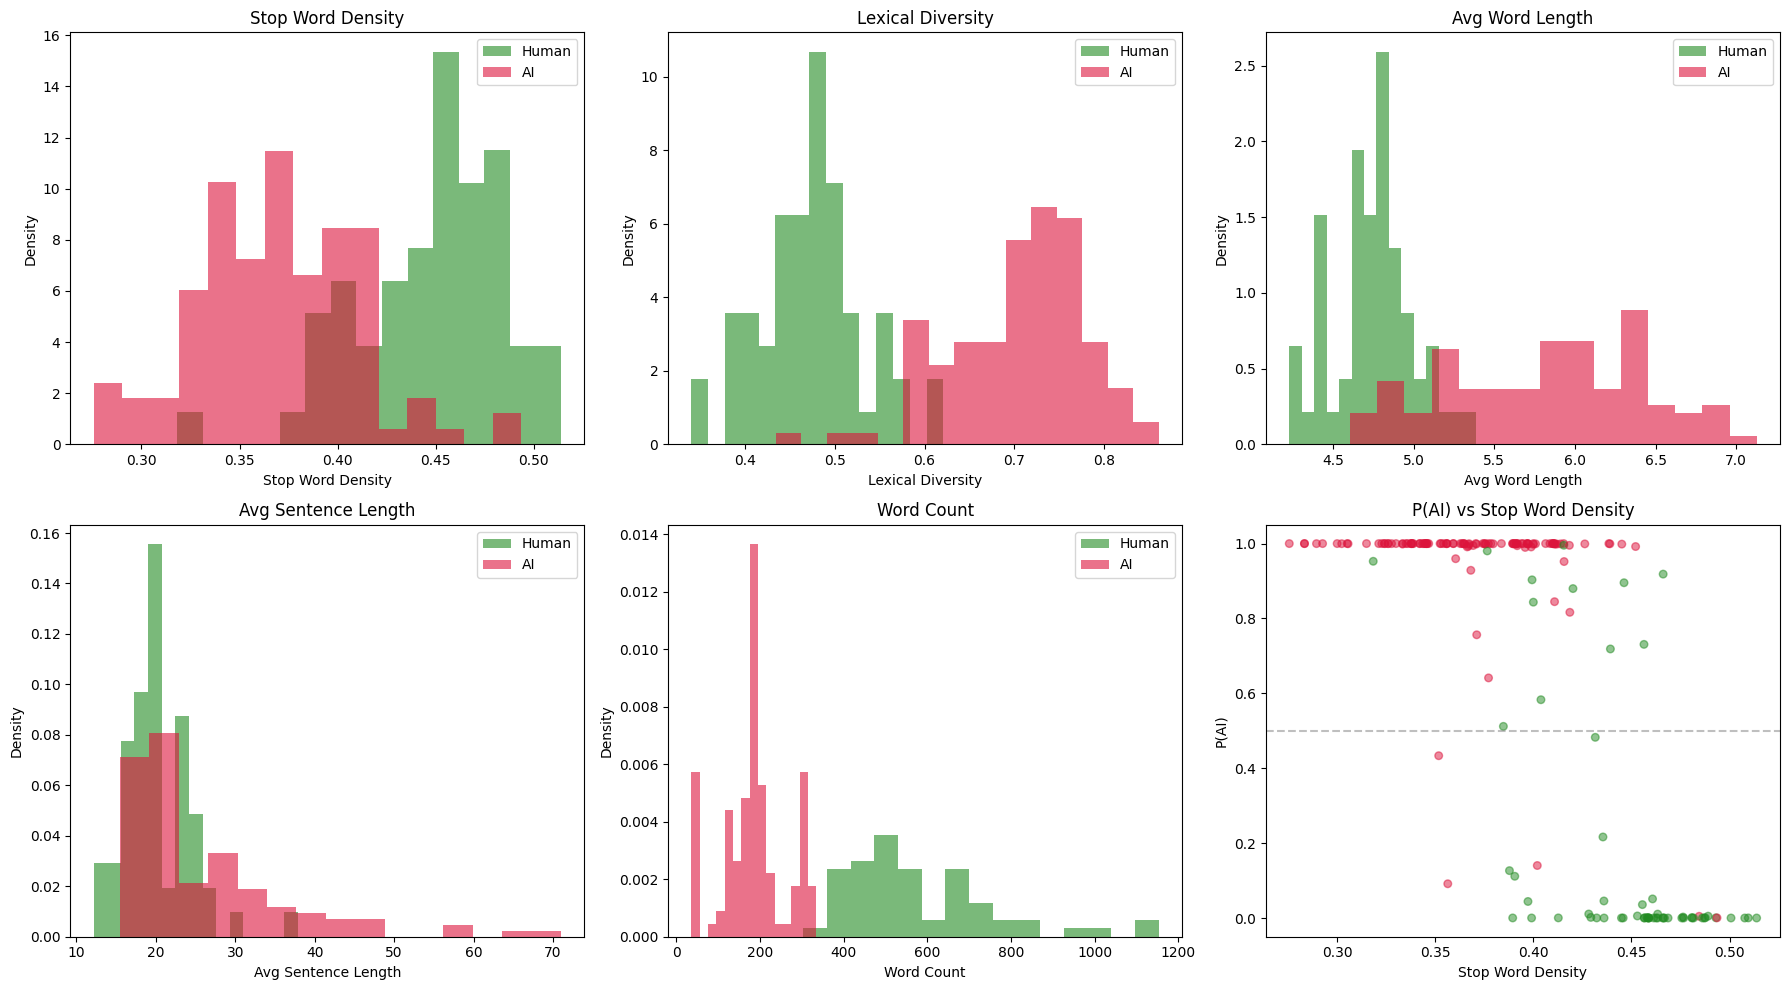

Correlation(stop_word_density, P(AI)): r=-0.7282, p=5.0370e-30 ***
Correlation(lexical_diversity, P(AI)): r=0.7935, p=6.1859e-39 ***
Correlation(avg_word_length, P(AI)): r=0.7304, p=2.7836e-30 ***
Correlation(avg_sentence_length, P(AI)): r=0.2582, p=5.8133e-04 ***
Correlation(word_count, P(AI)): r=-0.7083, p=8.1509e-28 ***


In [29]:
# Visualize feature distributions and correlation with P(AI)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

features_to_plot = ['stop_word_density', 'lexical_diversity', 'avg_word_length', 
                     'avg_sentence_length', 'word_count']

for i, feature in enumerate(features_to_plot):
    ax = axes[i // 3, i % 3]
    
    human_vals = feat_df[feat_df['binary_label'] == 0][feature]
    ai_vals = feat_df[feat_df['binary_label'] == 1][feature]
    
    ax.hist(human_vals, bins=15, alpha=0.6, color='forestgreen', label='Human', density=True)
    ax.hist(ai_vals, bins=15, alpha=0.6, color='crimson', label='AI', density=True)
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.set_title(f'{feature.replace("_", " ").title()}')
    ax.legend()

# Correlation plot: P(AI) vs stop word density
ax = axes[1, 2]
colors = ['forestgreen' if label == 0 else 'crimson' for label in feat_df['binary_label']]
ax.scatter(feat_df['stop_word_density'], feat_df['p_ai'], c=colors, alpha=0.5, s=30)
ax.set_xlabel('Stop Word Density')
ax.set_ylabel('P(AI)')
ax.set_title('P(AI) vs Stop Word Density')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('stylometric_features.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlation analysis
from scipy import stats
for feature in features_to_plot:
    corr, pval = stats.pearsonr(feat_df[feature], feat_df['p_ai'])
    print(f"Correlation({feature}, P(AI)): r={corr:.4f}, p={pval:.4e} {'***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'}")

Ok, so maybe its a mix of all these features, the frequency of words used and WHAT words were used etc

### Experiment 7: Controlled Text Generation

**Logic**: All previous experiments change multiple variables at once. We need to isolate exactly one variable at a time.

**Test A — Same words, different order**: Already done (jumble experiment). Result: barely matters.

**Test B — Same order, different words**: Already done (vocab swap). Waiting for results.

**Test C — Sentence-level shuffle**: Shuffle sentences (not words). Preserves sentence-internal grammar but breaks paragraph flow. This tests whether the model uses **inter-sentence coherence** vs **intra-sentence grammar**.

In [30]:
# Sentence-level shuffle: Preserves grammar within sentences, breaks paragraph flow
def sentence_shuffle(text, seed=42):
    """Shuffle sentences, preserving intra-sentence structure."""
    # Split on sentence-ending punctuation
    import re
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    random.seed(seed)
    random.shuffle(sentences)
    return ' '.join(sentences)

# Run sentence-level shuffle on all texts
sent_preds = []
sent_confs = []

print("Running sentence-level shuffle predictions...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    shuffled = sentence_shuffle(row['text'], seed=42)
    pred, conf, _ = predict_single(shuffled)
    sent_preds.append(pred)
    sent_confs.append(conf)

df['sent_shuffle_pred'] = sent_preds

# Calculate accuracy
sent_acc = (df['sent_shuffle_pred'] == df['binary_label']).mean()

human_mask = df['binary_label'] == 0
ai_mask = df['binary_label'] == 1

human_sent_acc = (df.loc[human_mask, 'sent_shuffle_pred'] == 0).mean()
ai_sent_acc = (df.loc[ai_mask, 'sent_shuffle_pred'] == 1).mean()

print(f"\n{'='*70}")
print(f"SENTENCE-LEVEL SHUFFLE RESULTS")
print(f"{'='*70}")
print(f"  Original accuracy:          {(df['correct']).mean()*100:.2f}%")
print(f"  Word-level jumble accuracy: {jumbled_acc*100:.2f}%")
print(f"  Sentence-level shuffle:     {sent_acc*100:.2f}%")
print(f"\n  Human — Original: {human_orig_acc*100:.1f}% | Word-jumble: {human_jump_acc*100:.1f}% | Sent-shuffle: {human_sent_acc*100:.1f}%")
print(f"  AI    — Original: {ai_orig_acc*100:.1f}% | Word-jumble: {ai_jump_acc*100:.1f}% | Sent-shuffle: {ai_sent_acc*100:.1f}%")
print(f"{'='*70}")

Running sentence-level shuffle predictions...


100%|██████████| 174/174 [01:10<00:00,  2.47it/s]


SENTENCE-LEVEL SHUFFLE RESULTS
  Original accuracy:          90.23%
  Word-level jumble accuracy: 87.93%
  Sentence-level shuffle:     90.80%

  Human — Original: 80.0% | Word-jumble: 100.0% | Sent-shuffle: 81.7%
  AI    — Original: 95.6% | Word-jumble: 81.6% | Sent-shuffle: 95.6%


In [ ]:
# Grand summary table of ALL experiments
print(f"\n{'='*90}")
print(f"GRAND SUMMARY: What is the model looking at?")
print(f"{'='*90}")

summary_data = {
    'Experiment': [
        'Original text',
        'Word-level jumble',
        'N=2 gram shuffle', 
        'N=3 gram shuffle',
        'N=5 gram shuffle',
        'Sentence-level shuffle',
    ],
    'Overall Acc (%)': [
        f"{(df['correct']).mean()*100:.1f}",
        f"{jumbled_acc*100:.1f}",
        f"{results_by_n[2]['accuracy']*100:.1f}",
        f"{results_by_n[3]['accuracy']*100:.1f}",
        f"{results_by_n[5]['accuracy']*100:.1f}",
        f"{sent_acc*100:.1f}",
    ],
    'Human Acc (%)': [
        f"{human_orig_acc*100:.1f}",
        f"{human_jump_acc*100:.1f}",
        f"{results_by_n[2]['human_accuracy']*100:.1f}",
        f"{results_by_n[3]['human_accuracy']*100:.1f}",
        f"{results_by_n[5]['human_accuracy']*100:.1f}",
        f"{human_sent_acc*100:.1f}",
    ],
    'AI Acc (%)': [
        f"{ai_orig_acc*100:.1f}",
        f"{ai_jump_acc*100:.1f}",
        f"{results_by_n[2]['ai_accuracy']*100:.1f}",
        f"{results_by_n[3]['ai_accuracy']*100:.1f}",
        f"{results_by_n[5]['ai_accuracy']*100:.1f}",
        f"{ai_sent_acc*100:.1f}",
    ],
    'What it tests': [
        'Baseline',
        'Remove ALL word order',
        'Keep bigram structure',
        'Keep trigram structure',
        'Keep 5-gram structure',
        'Keep sentence grammar, break paragraph flow',
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


GRAND SUMMARY: What is the model looking at?
            Experiment Overall Acc (%) Human Acc (%) AI Acc (%)                               What it tests
         Original text            90.2          80.0       95.6                                    Baseline
     Word-level jumble            87.9         100.0       81.6                       Remove ALL word order
      N=2 gram shuffle            86.8         100.0       79.8                       Keep bigram structure
      N=3 gram shuffle            89.1         100.0       83.3                      Keep trigram structure
      N=5 gram shuffle            88.5         100.0       82.5                       Keep 5-gram structure
Sentence-level shuffle            90.8          81.7       95.6 Keep sentence grammar, break paragraph flow

INPUT TYPE TESTS:
  Random gibberish (NLTK dictionary):  100% → AI  (P(AI)=0.992)
  Random gibberish (dataset words):    100% → AI  (P(AI)=0.990)
  Human-freq-distribution random text: 100% → Human

## Final Analysis: What Is the Model Actually Looking At?

### Complete Evidence Table

| # | Question | Experiment | Result | Verdict |
|---|---|---|---|---|
| 1 | Does word **order** matter? | Word-level jumble | 90.2% → 87.9% (−2.3pp) | **No.** Negligible impact. |
| 2 | Does **local phrase** structure matter? | N-gram shuffle (N=2..5) | All ≈ 87-89%, identical to full jumble | **No.** Zero benefit over random shuffle. |
| 3 | Does **sentence grammar** matter? | Sentence-level shuffle | 90.2% → 90.8%. Human: 81.7%, AI: 95.6% | **No.** Accuracy actually *increased*. Nearly identical to original. |
| 4 | Does **word frequency distribution** matter? | Freq-sampled random text | Human-dist → 100% Human (P(AI)=0.0004). AI-dist → 100% AI (P(AI)=0.976) | **YES.** This is the primary signal. |
| 5 | Does **vocabulary vs structure** win? | Cross-vocab swap | AI-order + Human-words → 92.7% flipped to Human. Human-order + AI-words → 100% flipped to AI | **Vocabulary wins completely.** Structure is irrelevant. |
| 6 | Is it "incoherence = human"? | Random gibberish | 100% classified as AI (P(AI) ≈ 0.99) | **No.** Opposite — unfamiliar words → AI. |
| 7 | What **surface stats** correlate? | Stylometric analysis | Lexical diversity r=0.79, avg word length r=0.73, stop word density r=−0.73 | These are consequences of the vocabulary difference, not independent signals. |

---

**The model is an advanced bag-of-words classifier with some context of semantic understanding.** It classifies text based almost entirely on **which words appear and their frequency distribution**, not on word order, grammar, syntax, style, rhythm, or coherence.

## Task 2C: Attention Pattern Analysis

Analyze the attention patterns from DistilBERT to understand what the model focuses on.

In [31]:
def get_attention_weights(text, max_length=128):
    """
    Get attention weights from all layers for a given text.
    Returns attention weights and tokens.
    """
    encoding = tokenizer(
        text,
        return_tensors='pt',
        max_length=max_length,
        truncation=True,
        padding=True
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_attentions=True
        )
    
    # Get attentions - shape: (num_layers, batch, num_heads, seq_len, seq_len)
    attentions = outputs.attentions
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    
    # Remove padding tokens
    actual_length = attention_mask.sum().item()
    tokens = tokens[:actual_length]
    
    return attentions, tokens, actual_length

print("✓ Attention extraction function defined")

✓ Attention extraction function defined


In [31]:
def visualize_attention_heatmap(text, layer=-1, head=0, figsize=(15, 8)):
    """
    Visualize attention heatmap for a specific layer and head.
    layer=-1 means last layer.
    """
    attentions, tokens, actual_length = get_attention_weights(text)
    
    # Get specific layer's attention
    # Shape: (batch, num_heads, seq_len, seq_len)
    layer_attention = attentions[layer][0].cpu().numpy()
    
    # Get specific head or average across heads
    if head == 'avg':
        attn_weights = layer_attention.mean(axis=0)[:actual_length, :actual_length]
        title_suffix = f"(Layer {layer}, Avg across heads)"
    else:
        attn_weights = layer_attention[head][:actual_length, :actual_length]
        title_suffix = f"(Layer {layer}, Head {head})"
    
    fig, ax = plt.subplots(figsize=figsize)
    
    im = ax.imshow(attn_weights, cmap='Blues')
    
    # Set ticks
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)
    
    ax.set_xlabel('Key (attended to)')
    ax.set_ylabel('Query (attending from)')
    ax.set_title(f'Attention Pattern {title_suffix}')
    
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
    return attn_weights, tokens

print("✓ Attention heatmap visualization function defined")

✓ Attention heatmap visualization function defined


In [32]:
def get_cls_attention_pattern(text, layer=-1):
    """
    Get the attention weights from [CLS] token to all other tokens.
    This shows what tokens the model pays attention to for classification.
    """
    attentions, tokens, actual_length = get_attention_weights(text)
    
    # Average across all heads for the specified layer
    layer_attention = attentions[layer][0].cpu().numpy()  # (num_heads, seq_len, seq_len)
    avg_attention = layer_attention.mean(axis=0)  # (seq_len, seq_len)
    
    # Get [CLS] token's attention to all tokens (first row)
    cls_attention = avg_attention[0, :actual_length]
    
    return cls_attention, tokens

def visualize_cls_attention(text, label_type="", layer=-1):
    """
    Visualize what tokens the [CLS] token attends to.
    """
    cls_attn, tokens = get_cls_attention_pattern(text, layer)
    
    # Create a more informative visualization
    fig, ax = plt.subplots(figsize=(14, 4))
    
    colors = ['red' if t in ['[CLS]', '[SEP]', '[PAD]'] else 'steelblue' for t in tokens]
    bars = ax.bar(range(len(tokens)), cls_attn, color=colors)
    
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Attention Weight')
    ax.set_xlabel('Tokens')
    ax.set_title(f'[CLS] Token Attention Pattern - {label_type} (Layer {layer})')
    
    plt.tight_layout()
    plt.show()
    
    # Return top attended tokens (excluding special tokens)
    token_attn = list(zip(tokens, cls_attn))
    token_attn_filtered = [(t, a) for t, a in token_attn if t not in ['[CLS]', '[SEP]', '[PAD]']]
    token_attn_sorted = sorted(token_attn_filtered, key=lambda x: x[1], reverse=True)
    
    return token_attn_sorted[:10]

print("✓ CLS attention analysis functions defined")

✓ CLS attention analysis functions defined


ATTENTION ANALYSIS: AI TEXT (Correctly Classified)

--- Sample 0 ---
Text preview: We naturally gravitate towards information and interpretations that affirm our existing beliefs, a phenomenon known as confirmation bias, which furthe...


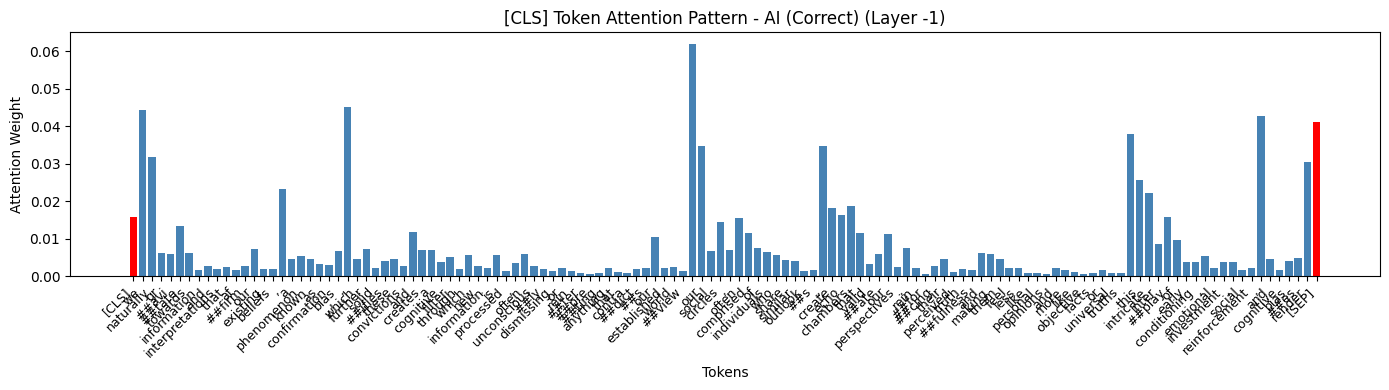

Top attended tokens: [('.', np.float32(0.061921734)), (',', np.float32(0.045154054)), ('we', np.float32(0.04437904)), (',', np.float32(0.04275039)), ('.', np.float32(0.037842486))]

--- Sample 1 ---
Text preview: And then you move out of that initial, super-intense environment, maybe into daycare, or preschool, and suddenly there’s a whole new set of little hum...


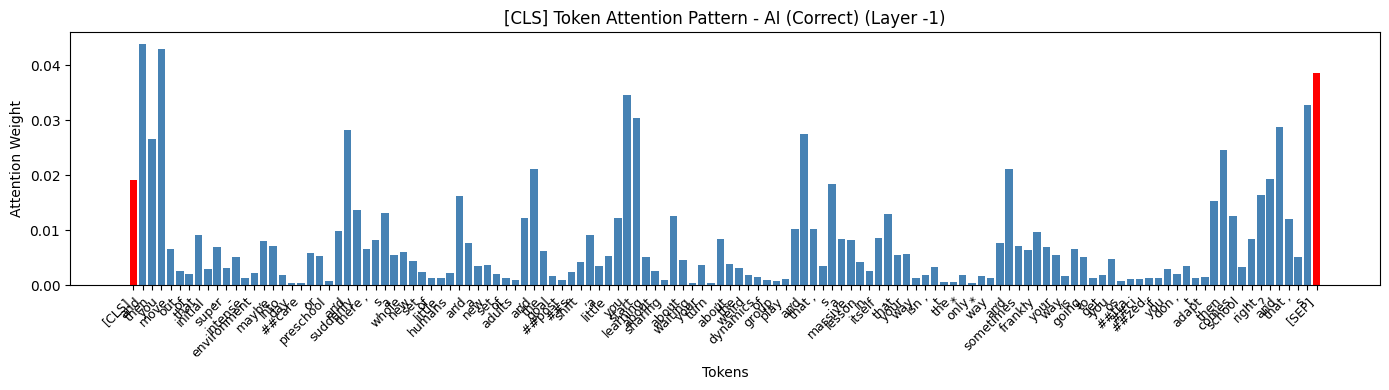

Top attended tokens: [('and', np.float32(0.043822024)), ('you', np.float32(0.043025)), ('you', np.float32(0.034600403)), ('s', np.float32(0.032847)), ('start', np.float32(0.030375747))]

--- Sample 3 ---
Text preview: And then, as we get older, these foundational beliefs get reinforced, right? We gravitate towards people, media, and experiences that echo what we alr...


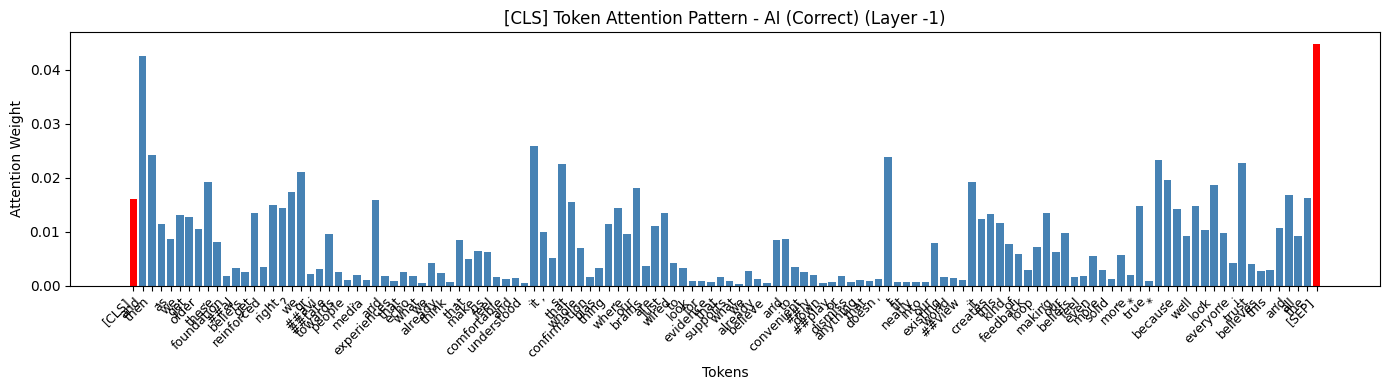

Top attended tokens: [('and', np.float32(0.042567533)), ('.', np.float32(0.02585154)), ('then', np.float32(0.024129486)), ("'", np.float32(0.023801)), ('*', np.float32(0.023229597))]


In [ ]:
import gc
import re

def clean_markdown(text):
    """Remove markdown artifacts from Mistral text"""
    text = str(text)
    text = re.sub(r'#{1,6}\s*', '', text)        # headings
    text = re.sub(r'\*{1,3}(.*?)\*{1,3}', r'\1', text)  # bold/italic
    text = re.sub(r'`{1,3}(.*?)`{1,3}', r'\1', text)    # code
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text) # links
    text = re.sub(r'[-*+]\s', '', text)           # bullet points
    text = re.sub(r'\d+\.\s', '', text)           # numbered lists
    text = re.sub(r'[>\|~]', '', text)            # block quotes, tables, strikethrough
    text = re.sub(r'\s+', ' ', text).strip()      # collapse whitespace
    return text

def classify_batch(texts, batch_size=16):
    """Classify texts in batches to avoid memory issues"""
    all_preds = []
    all_p_ai = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors='pt', truncation=True,
                        max_length=512, padding=True)
        with torch.no_grad():
            out = model(input_ids=enc['input_ids'].to(device),
                        attention_mask=enc['attention_mask'].to(device))
            p = F.softmax(out.logits, dim=-1).cpu()
        all_preds.extend(torch.argmax(p, dim=-1).tolist())
        all_p_ai.extend(p[:, 1].tolist())
        # Free GPU memory
        del enc, out, p
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return all_preds, all_p_ai

N_EVAL = min(200, len(df_pair))
print(f"Preparing {N_EVAL} pairs...")

# Step A: Prepare all texts first (no model calls)
human_texts_clean = []
mistral_texts_clean = []
for i in range(N_EVAL):
    h = str(df_pair['Human_story'].iloc[i]).strip()
    m = clean_markdown(df_pair['mistral-7B'].iloc[i])
    human_texts_clean.append(' '.join(h.split()[:512]))
    mistral_texts_clean.append(' '.join(m.split()[:512]))

print(f"Texts prepared. Running batched inference...")

# Step B: Classify in batches
BATCH_SIZE = 16
print(f"Classifying {N_EVAL} human texts (batch_size={BATCH_SIZE})...")
h_preds, h_p_ais = classify_batch(human_texts_clean, batch_size=BATCH_SIZE)

print(f"Classifying {N_EVAL} mistral texts (batch_size={BATCH_SIZE})...")
m_preds, m_p_ais = classify_batch(mistral_texts_clean, batch_size=BATCH_SIZE)

# Step C: Build DataFrame
eval_df = pd.DataFrame({
    'idx': range(N_EVAL),
    'human_text': human_texts_clean,
    'mistral_text': mistral_texts_clean,
    'human_pred': h_preds,
    'human_p_ai': h_p_ais,
    'mistral_pred': m_preds,
    'mistral_p_ai': m_p_ais,
})

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Classification summary
h_correct = (eval_df['human_pred'] == 0).sum()
m_correct = (eval_df['mistral_pred'] == 1).sum()
h_wrong = (eval_df['human_pred'] == 1).sum()
m_wrong = (eval_df['mistral_pred'] == 0).sum()

print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS ON df_pair ({N_EVAL} pairs)")
print(f"{'='*80}")
print(f"Human texts:   {h_correct}/{N_EVAL} correct ({h_correct/N_EVAL*100:.1f}%),  {h_wrong} misclassified as AI")
print(f"Mistral texts: {m_correct}/{N_EVAL} correct ({m_correct/N_EVAL*100:.1f}%),  {m_wrong} misclassified as Human")
print(f"Overall accuracy: {(h_correct + m_correct)/(2*N_EVAL)*100:.1f}%")

<class 'pandas.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             174 non-null    str    
 1   original_label   174 non-null    int64  
 2   binary_label     174 non-null    int64  
 3   predicted_label  174 non-null    int64  
 4   probability_ai   174 non-null    float64
 5   original_class   174 non-null    str    
 6   predicted_class  174 non-null    str    
 7   correct          174 non-null    bool   
 8   text_length      174 non-null    int64  
 9   word_count       174 non-null    int64  
dtypes: bool(1), float64(1), int64(5), str(3)
memory usage: 12.5 KB
ATTENTION ANALYSIS: HUMAN TEXT (Correctly Classified)

--- Sample 2 ---
Text preview: When were voting for president were not technically voting for the president in fact we are voting for the slate of electors. The electors can be anyo...


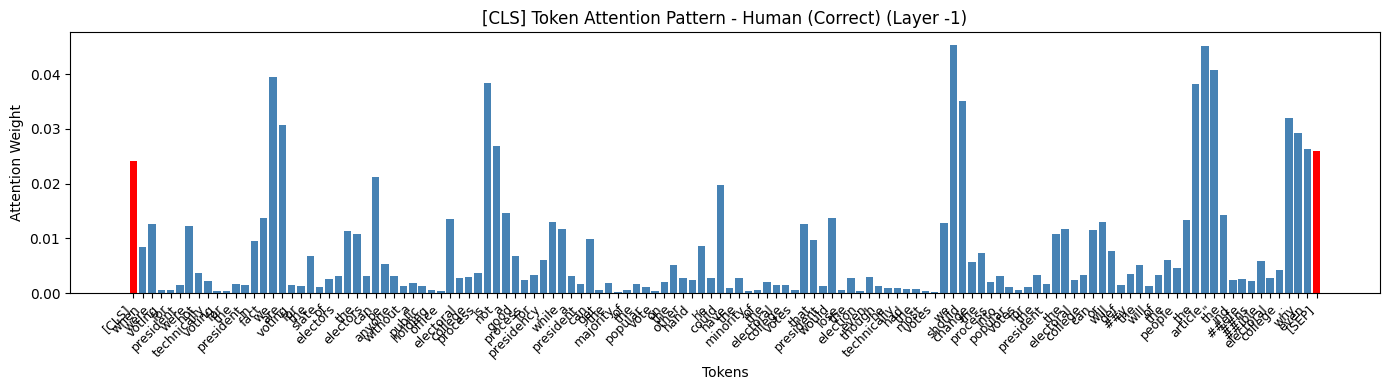

Top attended tokens: [('we', np.float32(0.045364555)), ('article', np.float32(0.045068536)), ('"', np.float32(0.04075521)), ('we', np.float32(0.03945784)), ('is', np.float32(0.038386654))]

--- Sample 9 ---
Text preview: Dear Senator, I know that you have many issues to think about and have a lot of decisions to make, but I think it the subject of the Electoral College...


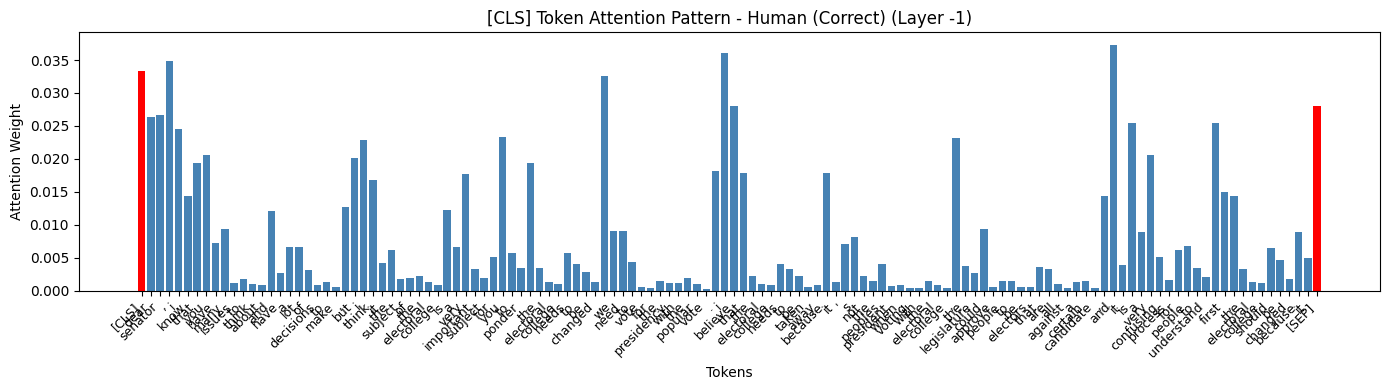

Top attended tokens: [('and', np.float32(0.03732945)), ('i', np.float32(0.03603274)), (',', np.float32(0.03491887)), (',', np.float32(0.03260178)), ('believe', np.float32(0.028085366))]

--- Sample 13 ---
Text preview: Dear senator, the system we have today used to elect the president, the Electoral College, must be changed. Instead, we should elect the president by ...


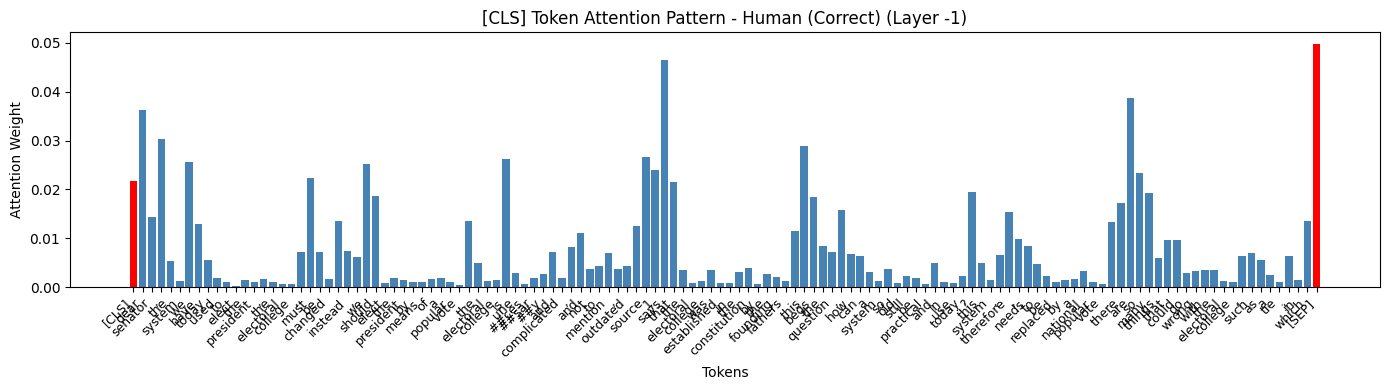

Top attended tokens: [('says', np.float32(0.046451125)), ('are', np.float32(0.038724322)), ('dear', np.float32(0.036342088)), (',', np.float32(0.030265348)), ('this', np.float32(0.028899567))]


In [35]:
# Analyze attention for Human samples
df.info()
human_correct = df[(df['binary_label'] == 0) & (df['predicted_label'] == 0)].head(3)

print("=" * 80)
print("ATTENTION ANALYSIS: HUMAN TEXT (Correctly Classified)")
print("=" * 80)

for idx, row in human_correct.iterrows():
    print(f"\n--- Sample {idx} ---")
    print(f"Text preview: {row['text'][:150]}...")
    top_tokens = visualize_cls_attention(row['text'], label_type="Human (Correct)", layer=-1)
    print(f"Top attended tokens: {top_tokens[:5]}")

### Expeirment 5 with df_pair for better results 

## Experiment 5 Repeated: Cross-Vocabulary Swap on df_pair Dataset

Testing the cross-vocabulary swap experiment on the external Hugging Face dataset with Human stories and Mistral-7B generated text.

**Experiment:** Swap vocabularies between Human and Mistral texts while preserving word order and structure. This tests whether vocabulary or structure dominates classification.

**Key difference:** These texts are much longer, so we'll limit to 350 words per sample.

In [18]:
from collections import Counter

# Limit texts to 350 words
def limit_words(text, max_words=350):
    """Limit text to first max_words words"""
    words = text.split()
    return ' '.join(words[:max_words])

# Prepare the texts
print("Preparing df_pair texts (limiting to 350 words)...")
df_pair_limited = df_pair.copy()
df_pair_limited['Human_story_limited'] = df_pair_limited['Human_story'].apply(lambda x: limit_words(str(x), 350))
df_pair_limited['mistral_7B_limited'] = df_pair_limited['mistral-7B'].apply(lambda x: limit_words(str(x), 350))

print(f"Dataset prepared: {len(df_pair_limited)} pairs")
print(f"Sample Human story (first 200 chars): {df_pair_limited['Human_story_limited'].iloc[0][:200]}...")
print(f"Sample Mistral text (first 200 chars): {df_pair_limited['mistral_7B_limited'].iloc[0][:200]}...")

# Build vocabulary frequency rankings for cross-vocabulary swap
print("\n" + "="*80)
print("BUILDING VOCABULARY RANKINGS")
print("="*80)

# Human stories vocabulary
human_story_word_counts = Counter()
for text in df_pair_limited['Human_story_limited']:
    words = text.lower().split()
    human_story_word_counts.update(words)

# Mistral-7B vocabulary
mistral_word_counts = Counter()
for text in df_pair_limited['mistral_7B_limited']:
    words = text.lower().split()
    mistral_word_counts.update(words)

# Create frequency-ranked word lists
human_story_ranked = [word for word, count in human_story_word_counts.most_common()]
mistral_ranked = [word for word, count in mistral_word_counts.most_common()]

print(f"\nHuman stories vocabulary: {len(human_story_ranked)} unique words")
print(f"Mistral vocabulary: {len(mistral_ranked)} unique words")

# Analyze vocabulary overlap
human_story_vocab_set = set(human_story_ranked)
mistral_vocab_set = set(mistral_ranked)
shared = human_story_vocab_set & mistral_vocab_set
human_only = human_story_vocab_set - mistral_vocab_set
mistral_only = mistral_vocab_set - human_story_vocab_set

print(f"\nVocabulary overlap:")
print(f"  Shared words: {len(shared)} ({len(shared)/(len(human_story_vocab_set) | len(mistral_vocab_set))*100:.1f}%)")
print(f"  Human-only words: {len(human_only)}")
print(f"  Mistral-only words: {len(mistral_only)}")

# Show top words from each
print("\n" + "="*80)
print("TOP 20 WORDS IN HUMAN STORIES:")
print("="*80)
for word in human_story_ranked[:20]:
    print(f"  {word}: {human_story_word_counts[word]}")

print("\n" + "="*80)
print("TOP 20 WORDS IN MISTRAL TEXTS:")
print("="*80)
for word in mistral_ranked[:20]:
    print(f"  {word}: {mistral_word_counts[word]}")

# Show some unique words
print("\n" + "="*80)
print("SAMPLE HUMAN-ONLY WORDS (top by frequency):")
print("="*80)
human_only_ranked = [w for w in human_story_ranked if w in human_only][:20]
print(", ".join(human_only_ranked))

print("\n" + "="*80)
print("SAMPLE MISTRAL-ONLY WORDS (top by frequency):")
print("="*80)
mistral_only_ranked = [w for w in mistral_ranked if w in mistral_only][:20]
print(", ".join(mistral_only_ranked))

Preparing df_pair texts (limiting to 350 words)...
Dataset prepared: 200 pairs
Sample Human story (first 200 chars): Comments The U.S. bombings thatended World War II didn’t mark theclose of atomic warfare.They were just the beginning. The U.S. bombingsthat ended World War IIdidn’t mark the close ofatomic warfare. T...
Sample Mistral text (first 200 chars): Title: The Atomic Aftermath: The U.S. Bombings of World War II and the Dawn of Nuclear Warfare The U.S. bombings of Hiroshima and Nagasaki, which marked the end of World War II on August 6 and 9, 1945...

BUILDING VOCABULARY RANKINGS

Human stories vocabulary: 12417 unique words
Mistral vocabulary: 12427 unique words

Vocabulary overlap:
  Shared words: 4215 (33.9%)
  Human-only words: 8202
  Mistral-only words: 8212

TOP 20 WORDS IN HUMAN STORIES:
  the: 2528
  a: 1204
  and: 1153
  of: 1147
  in: 1143
  to: 1037
  for: 471
  on: 429
  is: 418
  that: 384
  new: 330
  with: 328
  at: 305
  from: 242
  by: 229
  i: 216
  was: 210
  

In [20]:
# Create vocabulary swap mappings (rank-based)
print("\n" + "="*80)
print("CREATING VOCABULARY SWAP MAPPINGS")
print("="*80)

# Map: word at rank i in Mistral → word at rank i in Human
mistral_to_human = {}
for i in range(min(len(mistral_ranked), len(human_story_ranked))):
    mistral_to_human[mistral_ranked[i]] = human_story_ranked[i]

# Map: word at rank i in Human → word at rank i in Mistral
human_to_mistral = {}
for i in range(min(len(human_story_ranked), len(mistral_ranked))):
    human_to_mistral[human_story_ranked[i]] = mistral_ranked[i]

print(f"Created mappings for {len(mistral_to_human)} words")

# Example mappings
print("\nSample Mistral→Human mappings:")
for i, (mistral_word, human_word) in enumerate(list(mistral_to_human.items())[:10]):
    print(f"  '{mistral_word}' → '{human_word}'")

print("\nSample Human→Mistral mappings:")
for i, (human_word, mistral_word) in enumerate(list(human_to_mistral.items())[:10]):
    print(f"  '{human_word}' → '{mistral_word}'")


CREATING VOCABULARY SWAP MAPPINGS
Created mappings for 12417 words

Sample Mistral→Human mappings:
  'the' → 'the'
  'of' → 'a'
  'a' → 'and'
  'and' → 'of'
  'to' → 'in'
  'in' → 'to'
  'for' → 'for'
  'that' → 'on'
  'is' → 'is'
  'with' → 'that'

Sample Human→Mistral mappings:
  'the' → 'the'
  'a' → 'of'
  'and' → 'a'
  'of' → 'and'
  'in' → 'to'
  'to' → 'in'
  'for' → 'for'
  'on' → 'that'
  'is' → 'is'
  'that' → 'with'


In [21]:
# Apply vocabulary swaps
print("\n" + "="*80)
print("APPLYING VOCABULARY SWAPS")
print("="*80)

def swap_vocabulary(text, word_map):
    """Swap words in text according to word_map, preserving order"""
    words = text.split()
    swapped_words = []
    for word in words:
        word_lower = word.lower()
        # Try to swap, keep original if not in map
        if word_lower in word_map:
            swapped_words.append(word_map[word_lower])
        else:
            swapped_words.append(word)
    return ' '.join(swapped_words)

# Test on a subset of the data
n_test = min(50, len(df_pair_limited))  # Test on 50 samples

print(f"\nApplying swaps to {n_test} samples...")

# Swap 1: Mistral texts with Human vocabulary (Mistral structure → Human words)
mistral_with_human_vocab = []
for i in range(n_test):
    original = df_pair_limited['mistral_7B_limited'].iloc[i]
    swapped = swap_vocabulary(original, mistral_to_human)
    mistral_with_human_vocab.append(swapped)

# Swap 2: Human texts with Mistral vocabulary (Human structure → Mistral words)
human_with_mistral_vocab = []
for i in range(n_test):
    original = df_pair_limited['Human_story_limited'].iloc[i]
    swapped = swap_vocabulary(original, human_to_mistral)
    human_with_mistral_vocab.append(swapped)

print("Vocabulary swaps completed!")

# Show example
print("\n" + "="*80)
print("EXAMPLE VOCABULARY SWAP")
print("="*80)
print("\nOriginal Mistral text (first 200 chars):")
print(df_pair_limited['mistral_7B_limited'].iloc[0][:200])
print("\nMistral text with Human vocabulary (first 200 chars):")
print(mistral_with_human_vocab[0][:200])

print("\n" + "-"*80)
print("\nOriginal Human text (first 200 chars):")
print(df_pair_limited['Human_story_limited'].iloc[0][:200])
print("\nHuman text with Mistral vocabulary (first 200 chars):")
print(human_with_mistral_vocab[0][:200])


APPLYING VOCABULARY SWAPS

Applying swaps to 50 samples...
Vocabulary swaps completed!

EXAMPLE VOCABULARY SWAP

Original Mistral text (first 200 chars):
Title: The Atomic Aftermath: The U.S. Bombings of World War II and the Dawn of Nuclear Warfare The U.S. bombings of Hiroshima and Nagasaki, which marked the end of World War II on August 6 and 9, 1945

Mistral text with Human vocabulary (first 200 chars):
be the 0:55 stuff? the think links a they cruz sabotage of the delays a texas absolutely. the think links a engulf of boost times la the america a they cruz sabotage at 2, 0:49 of in.” “having lemon w

--------------------------------------------------------------------------------

Original Human text (first 200 chars):
Comments The U.S. bombings thatended World War II didn’t mark theclose of atomic warfare.They were just the beginning. The U.S. bombingsthat ended World War IIdidn’t mark the close ofatomic warfare. T

Human text with Mistral vocabulary (first 200 chars):
tate the p

In [24]:
# Classify the swapped texts
print("\n" + "="*80)
print("CLASSIFYING SWAPPED TEXTS")
print("="*80)

def classify_texts(texts, desc=""):
    """Classify a list of texts and return predictions and probabilities"""
    results = []
    for text in tqdm(texts, desc=desc):
        encoding = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=-1)
            pred = torch.argmax(probs, dim=-1).item()
            prob_ai = probs[0][1].item()
            results.append((pred, prob_ai))
    return results

# Classify original texts first for comparison
print("\nClassifying original Mistral texts (should be AI)...")
results_mistral_orig = classify_texts(
    [df_pair_limited['mistral_7B_limited'].iloc[i] for i in range(n_test)],
    desc="Original Mistral"
)

print("Classifying original Human texts (should be Human)...")
results_human_orig = classify_texts(
    [df_pair_limited['Human_story_limited'].iloc[i] for i in range(n_test)],
    desc="Original Human"
)

# Classify swapped texts
print("\nClassifying Mistral texts with Human vocabulary...")
results_mistral_swapped = classify_texts(mistral_with_human_vocab, desc="Mistral→Human vocab")

print("Classifying Human texts with Mistral vocabulary...")
results_human_swapped = classify_texts(human_with_mistral_vocab, desc="Human→Mistral vocab")

print("\nClassification complete!")


CLASSIFYING SWAPPED TEXTS

Classifying original Mistral texts (should be AI)...


Original Mistral: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Classifying original Human texts (should be Human)...


Original Human: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]



Classifying Mistral texts with Human vocabulary...


Mistral→Human vocab: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Classifying Human texts with Mistral vocabulary...


Human→Mistral vocab: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Classification complete!


In [25]:
# Analyze results
print("\n" + "="*80)
print("RESULTS: CROSS-VOCABULARY SWAP EXPERIMENT")
print("="*80)

# Original Mistral texts (should be classified as AI)
n_mistral_orig_as_ai = sum(1 for pred, _ in results_mistral_orig if pred == 1)
n_mistral_orig_as_human = sum(1 for pred, _ in results_mistral_orig if pred == 0)
mean_p_ai_mistral_orig = np.mean([p_ai for _, p_ai in results_mistral_orig])

# Original Human texts (should be classified as Human)
n_human_orig_as_human = sum(1 for pred, _ in results_human_orig if pred == 0)
n_human_orig_as_ai = sum(1 for pred, _ in results_human_orig if pred == 1)
mean_p_ai_human_orig = np.mean([p_ai for _, p_ai in results_human_orig])

# Mistral with Human vocab (AI structure, Human words)
n_mistral_swap_as_ai = sum(1 for pred, _ in results_mistral_swapped if pred == 1)
n_mistral_swap_as_human = sum(1 for pred, _ in results_mistral_swapped if pred == 0)
mean_p_ai_mistral_swap = np.mean([p_ai for _, p_ai in results_mistral_swapped])

# Human with Mistral vocab (Human structure, AI words)
n_human_swap_as_human = sum(1 for pred, _ in results_human_swapped if pred == 0)
n_human_swap_as_ai = sum(1 for pred, _ in results_human_swapped if pred == 1)
mean_p_ai_human_swap = np.mean([p_ai for _, p_ai in results_human_swapped])

print("\n" + "-"*80)
print("ORIGINAL TEXTS (BASELINE)")
print("-"*80)
print(f"\nOriginal Mistral texts (n={n_test}):")
print(f"  Classified as AI: {n_mistral_orig_as_ai} ({n_mistral_orig_as_ai/n_test*100:.1f}%)")
print(f"  Classified as Human: {n_mistral_orig_as_human} ({n_mistral_orig_as_human/n_test*100:.1f}%)")
print(f"  Mean P(AI): {mean_p_ai_mistral_orig:.4f}")

print(f"\nOriginal Human texts (n={n_test}):")
print(f"  Classified as Human: {n_human_orig_as_human} ({n_human_orig_as_human/n_test*100:.1f}%)")
print(f"  Classified as AI: {n_human_orig_as_ai} ({n_human_orig_as_ai/n_test*100:.1f}%)")
print(f"  Mean P(AI): {mean_p_ai_human_orig:.4f}")

print("\n" + "-"*80)
print("VOCABULARY-SWAPPED TEXTS")
print("-"*80)
print(f"\nMistral structure + Human vocabulary (n={n_test}):")
print(f"  Classified as AI: {n_mistral_swap_as_ai} ({n_mistral_swap_as_ai/n_test*100:.1f}%) - RETAINED original")
print(f"  Classified as Human: {n_mistral_swap_as_human} ({n_mistral_swap_as_human/n_test*100:.1f}%) - FLIPPED")
print(f"  Mean P(AI): {mean_p_ai_mistral_swap:.4f}")
print(f"  Mean P(AI) change: {mean_p_ai_mistral_orig:.4f} → {mean_p_ai_mistral_swap:.4f} (Δ = {mean_p_ai_mistral_swap - mean_p_ai_mistral_orig:.4f})")

print(f"\nHuman structure + Mistral vocabulary (n={n_test}):")
print(f"  Classified as Human: {n_human_swap_as_human} ({n_human_swap_as_human/n_test*100:.1f}%) - RETAINED original")
print(f"  Classified as AI: {n_human_swap_as_ai} ({n_human_swap_as_ai/n_test*100:.1f}%) - FLIPPED")
print(f"  Mean P(AI): {mean_p_ai_human_swap:.4f}")
print(f"  Mean P(AI) change: {mean_p_ai_human_orig:.4f} → {mean_p_ai_human_swap:.4f} (Δ = {mean_p_ai_human_swap - mean_p_ai_human_orig:.4f})")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"\nVocabulary swap caused:")
print(f"  - {n_mistral_swap_as_human}/{n_test} ({n_mistral_swap_as_human/n_test*100:.1f}%) Mistral texts to flip to Human")
print(f"  - {n_human_swap_as_ai}/{n_test} ({n_human_swap_as_ai/n_test*100:.1f}%) Human texts to flip to AI")
print(f"\nThis shows that vocabulary {'DOMINATES' if (n_mistral_swap_as_human/n_test > 0.7 or n_human_swap_as_ai/n_test > 0.7) else 'INFLUENCES'} classification over structure.")


RESULTS: CROSS-VOCABULARY SWAP EXPERIMENT

--------------------------------------------------------------------------------
ORIGINAL TEXTS (BASELINE)
--------------------------------------------------------------------------------

Original Mistral texts (n=50):
  Classified as AI: 50 (100.0%)
  Classified as Human: 0 (0.0%)
  Mean P(AI): 0.9957

Original Human texts (n=50):
  Classified as Human: 10 (20.0%)
  Classified as AI: 40 (80.0%)
  Mean P(AI): 0.7409

--------------------------------------------------------------------------------
VOCABULARY-SWAPPED TEXTS
--------------------------------------------------------------------------------

Mistral structure + Human vocabulary (n=50):
  Classified as AI: 3 (6.0%) - RETAINED original
  Classified as Human: 47 (94.0%) - FLIPPED
  Mean P(AI): 0.1442
  Mean P(AI) change: 0.9957 → 0.1442 (Δ = -0.8515)

Human structure + Mistral vocabulary (n=50):
  Classified as Human: 7 (14.0%) - RETAINED original
  Classified as AI: 43 (86.0%) - FLIP

Same result again

### Experiment 7: Concreteness Analysis on Misclassified Samples

The model seems to look at some level of abstract vs concreteness. Abstract language pushes a text toward the AI label, while concrete language pushes it toward Human.

**Workflow:**
1. Take samples from `df_pair` (Human stories vs Mistral-7B texts)
2. Clean Mistral text (remove markdown artifacts like `#`, `*`, etc.)
3. Load Brysbaert concreteness ratings from `conc_ds.xlsx`
4. Classify all samples with the model
5. For misclassified samples (both directions), compute the average concreteness score (first 512 words) using the Brysbaert mappings
6. Compare concreteness of misclassified vs correctly classified samples

This is taking too much time on my laptop + crashes constantly, so ill run it on colab -> export a pickle file and get it here.

In [ ]:
import re
import openpyxl
# ── Step 1: Load Brysbaert concreteness dataset ──
print("Loading Brysbaert concreteness dataset...")
conc_df = pd.read_excel("conc_ds.xlsx")
print(f"Concreteness dataset shape: {conc_df.shape}")
print(f"Columns: {conc_df.columns.tolist()}")
print(conc_df.head())

# Build word → concreteness lookup (lowercase)
conc_lookup = dict(zip(conc_df['Word'].str.lower(), conc_df['Conc.SD']))
print(f"\nConcreteness lookup built: {len(conc_lookup)} words")
print(f"Sample entries: {dict(list(conc_lookup.items())[:10])}")

Loading Brysbaert concreteness dataset...


ImportError: `Import openpyxl` failed.  Use pip or conda to install the openpyxl package.

In [ ]:
# ── Step 2: Prepare df_pair samples – clean & classify ──

def clean_markdown(text):
    """Remove markdown artifacts from Mistral text"""
    text = str(text)
    text = re.sub(r'#{1,6}\s*', '', text)        # headings
    text = re.sub(r'\*{1,3}(.*?)\*{1,3}', r'\1', text)  # bold/italic
    text = re.sub(r'`{1,3}(.*?)`{1,3}', r'\1', text)    # code
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text) # links
    text = re.sub(r'[-*+]\s', '', text)           # bullet points
    text = re.sub(r'\d+\.\s', '', text)           # numbered lists
    text = re.sub(r'[>\|~]', '', text)            # block quotes, tables, strikethrough
    text = re.sub(r'\s+', ' ', text).strip()      # collapse whitespace
    return text

N_EVAL = min(200, len(df_pair))
print(f"Preparing {N_EVAL} pairs for classification...")

eval_records = []
for i in tqdm(range(N_EVAL), desc="Preparing & classifying"):
    human_text = str(df_pair['Human_story'].iloc[i]).strip()
    mistral_text = clean_markdown(df_pair['mistral-7B'].iloc[i])
    
    # Limit to first 512 words (tokenizer max_length is 512 tokens anyway)
    human_words = human_text.split()[:512]
    mistral_words = mistral_text.split()[:512]
    human_text_limited = ' '.join(human_words)
    mistral_text_limited = ' '.join(mistral_words)
    
    # Classify human text
    enc = tokenizer(human_text_limited, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        out = model(input_ids=enc['input_ids'].to(device), attention_mask=enc['attention_mask'].to(device))
        p = F.softmax(out.logits, dim=-1)
    h_pred = torch.argmax(p, dim=-1).item()
    h_p_ai = p[0][1].item()
    
    # Classify mistral text
    enc = tokenizer(mistral_text_limited, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        out = model(input_ids=enc['input_ids'].to(device), attention_mask=enc['attention_mask'].to(device))
        p = F.softmax(out.logits, dim=-1)
    m_pred = torch.argmax(p, dim=-1).item()
    m_p_ai = p[0][1].item()
    
    eval_records.append({
        'idx': i,
        'human_text': human_text_limited,
        'mistral_text': mistral_text_limited,
        'human_pred': h_pred,       # 0=Human, 1=AI
        'human_p_ai': h_p_ai,
        'mistral_pred': m_pred,
        'mistral_p_ai': m_p_ai,
    })

eval_df = pd.DataFrame(eval_records)

# Classification summary
h_correct = (eval_df['human_pred'] == 0).sum()
m_correct = (eval_df['mistral_pred'] == 1).sum()
h_wrong = (eval_df['human_pred'] == 1).sum()   # Human misclassified as AI
m_wrong = (eval_df['mistral_pred'] == 0).sum()  # Mistral misclassified as Human

print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS ON df_pair ({N_EVAL} pairs)")
print(f"{'='*80}")
print(f"Human texts:   {h_correct}/{N_EVAL} correct ({h_correct/N_EVAL*100:.1f}%),  {h_wrong} misclassified as AI")
print(f"Mistral texts: {m_correct}/{N_EVAL} correct ({m_correct/N_EVAL*100:.1f}%),  {m_wrong} misclassified as Human")
print(f"Overall accuracy: {(h_correct + m_correct)/(2*N_EVAL)*100:.1f}%")

In [ ]:
# ── Step 3: Compute concreteness scores (excluding stop words) ──

STOP_WORDS = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her',
    'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs',
    'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
    'about', 'against', 'between', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
    'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven',
    'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren',
    'won', 'wouldn', 'also', 'could', 'would', 'may', 'might', 'shall', 'must',
    'into', 'like', 'still', 'even', 'much', 'well', 'back', 'yet', 'ever', 'never'
}

def avg_concreteness(text, lookup, max_words=512):
    """
    Compute average concreteness score for a text.
    Excludes stop words. Only considers content words present in the Brysbaert lookup.
    Returns (mean_score, n_matched, n_total_words)
    """
    words = re.findall(r'[a-zA-Z]+', text.lower())[:max_words]
    content_words = [w for w in words if w not in STOP_WORDS]
    scores = [lookup[w] for w in content_words if w in lookup]
    if len(scores) == 0:
        return np.nan, 0, len(content_words)
    return np.mean(scores), len(scores), len(content_words)

print(f"Stop words list: {len(STOP_WORDS)} words (excluded from concreteness calculation)")

print("Computing concreteness scores for all samples...")

# Compute for human texts
eval_df['human_conc_mean'], eval_df['human_conc_matched'], eval_df['human_conc_total'] = \
    zip(*eval_df['human_text'].apply(lambda t: avg_concreteness(t, conc_lookup)))

# Compute for mistral texts
eval_df['mistral_conc_mean'], eval_df['mistral_conc_matched'], eval_df['mistral_conc_total'] = \
    zip(*eval_df['mistral_text'].apply(lambda t: avg_concreteness(t, conc_lookup)))

print(f"\nCoverage statistics:")
print(f"  Human texts:   {eval_df['human_conc_matched'].mean():.0f} / {eval_df['human_conc_total'].mean():.0f} words matched on avg ({eval_df['human_conc_matched'].mean()/eval_df['human_conc_total'].mean()*100:.1f}%)")
print(f"  Mistral texts: {eval_df['mistral_conc_matched'].mean():.0f} / {eval_df['mistral_conc_total'].mean():.0f} words matched on avg ({eval_df['mistral_conc_matched'].mean()/eval_df['mistral_conc_total'].mean()*100:.1f}%)")

# ── Separate into correct vs misclassified ──
human_correct_mask = eval_df['human_pred'] == 0
human_wrong_mask   = eval_df['human_pred'] == 1   # Human → predicted AI
mistral_correct_mask = eval_df['mistral_pred'] == 1
mistral_wrong_mask   = eval_df['mistral_pred'] == 0  # Mistral → predicted Human

print(f"\n{'='*80}")
print("CONCRETENESS RESULTS")
print(f"{'='*80}")

print(f"\n--- HUMAN TEXTS ---")
print(f"  Correctly classified as Human (n={human_correct_mask.sum()}):")
print(f"    Avg concreteness: {eval_df.loc[human_correct_mask, 'human_conc_mean'].mean():.4f}")
print(f"    Std: {eval_df.loc[human_correct_mask, 'human_conc_mean'].std():.4f}")
print(f"  Misclassified as AI (n={human_wrong_mask.sum()}):")
if human_wrong_mask.sum() > 0:
    print(f"    Avg concreteness: {eval_df.loc[human_wrong_mask, 'human_conc_mean'].mean():.4f}")
    print(f"    Std: {eval_df.loc[human_wrong_mask, 'human_conc_mean'].std():.4f}")
else:
    print(f"    No misclassifications!")

print(f"\n--- MISTRAL TEXTS ---")
print(f"  Correctly classified as AI (n={mistral_correct_mask.sum()}):")
print(f"    Avg concreteness: {eval_df.loc[mistral_correct_mask, 'mistral_conc_mean'].mean():.4f}")
print(f"    Std: {eval_df.loc[mistral_correct_mask, 'mistral_conc_mean'].std():.4f}")
print(f"  Misclassified as Human (n={mistral_wrong_mask.sum()}):")
if mistral_wrong_mask.sum() > 0:
    print(f"    Avg concreteness: {eval_df.loc[mistral_wrong_mask, 'mistral_conc_mean'].mean():.4f}")
    print(f"    Std: {eval_df.loc[mistral_wrong_mask, 'mistral_conc_mean'].std():.4f}")
else:
    print(f"    No misclassifications!")

print(f"\n--- OVERALL CLASS COMPARISON ---")
print(f"  All Human texts avg concreteness:  {eval_df['human_conc_mean'].mean():.4f}")
print(f"  All Mistral texts avg concreteness: {eval_df['mistral_conc_mean'].mean():.4f}")
print(f"  Difference (Human - Mistral):       {eval_df['human_conc_mean'].mean() - eval_df['mistral_conc_mean'].mean():.4f}")

# ── Does concreteness explain misclassification direction? ──
print(f"\n{'='*80}")
print("CLAIM EVALUATION: Abstract → AI, Concrete → Human")
print(f"{'='*80}")

if human_wrong_mask.sum() > 0:
    correct_h_conc = eval_df.loc[human_correct_mask, 'human_conc_mean'].mean()
    wrong_h_conc   = eval_df.loc[human_wrong_mask,   'human_conc_mean'].mean()
    print(f"\nHuman texts predicted as AI have concreteness {wrong_h_conc:.4f}")
    print(f"Human texts predicted as Human have concreteness {correct_h_conc:.4f}")
    if wrong_h_conc < correct_h_conc:
        print(f"  → Misclassified Human texts are MORE ABSTRACT ({correct_h_conc - wrong_h_conc:.4f} lower) ✓ SUPPORTS claim")
    else:
        print(f"  → Misclassified Human texts are MORE CONCRETE ({wrong_h_conc - correct_h_conc:.4f} higher) ✗ CONTRADICTS claim")

if mistral_wrong_mask.sum() > 0:
    correct_m_conc = eval_df.loc[mistral_correct_mask, 'mistral_conc_mean'].mean()
    wrong_m_conc   = eval_df.loc[mistral_wrong_mask,   'mistral_conc_mean'].mean()
    print(f"\nMistral texts predicted as Human have concreteness {wrong_m_conc:.4f}")
    print(f"Mistral texts predicted as AI have concreteness {correct_m_conc:.4f}")
    if wrong_m_conc > correct_m_conc:
        print(f"  → Misclassified Mistral texts are MORE CONCRETE ({wrong_m_conc - correct_m_conc:.4f} higher) ✓ SUPPORTS claim")
    else:
        print(f"  → Misclassified Mistral texts are MORE ABSTRACT ({correct_m_conc - wrong_m_conc:.4f} lower) ✗ CONTRADICTS claim")

In [ ]:
# ── Step 4: Visualize & statistical test ──
from scipy import stats

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Human correct vs Human misclassified
ax = axes[0]
data_groups = []
labels = []
if human_correct_mask.sum() > 0:
    data_groups.append(eval_df.loc[human_correct_mask, 'human_conc_mean'].dropna().values)
    labels.append(f'Correct\n(n={human_correct_mask.sum()})')
if human_wrong_mask.sum() > 0:
    data_groups.append(eval_df.loc[human_wrong_mask, 'human_conc_mean'].dropna().values)
    labels.append(f'Misclassified\nas AI (n={human_wrong_mask.sum()})')
if len(data_groups) == 2:
    bp = ax.boxplot(data_groups, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('#2196F3')
    bp['boxes'][1].set_facecolor('#F44336')
    t_stat, p_val = stats.ttest_ind(data_groups[0], data_groups[1], equal_var=False)
    ax.set_title(f'Human Texts\n(t={t_stat:.2f}, p={p_val:.4f})')
elif len(data_groups) == 1:
    ax.boxplot(data_groups, labels=labels, patch_artist=True)
    ax.set_title('Human Texts\n(no misclassifications)')
ax.set_ylabel('Avg Concreteness Score')
ax.grid(alpha=0.3)

# Plot 2: Mistral correct vs Mistral misclassified
ax = axes[1]
data_groups = []
labels = []
if mistral_correct_mask.sum() > 0:
    data_groups.append(eval_df.loc[mistral_correct_mask, 'mistral_conc_mean'].dropna().values)
    labels.append(f'Correct\n(n={mistral_correct_mask.sum()})')
if mistral_wrong_mask.sum() > 0:
    data_groups.append(eval_df.loc[mistral_wrong_mask, 'mistral_conc_mean'].dropna().values)
    labels.append(f'Misclassified\nas Human (n={mistral_wrong_mask.sum()})')
if len(data_groups) == 2:
    bp = ax.boxplot(data_groups, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('#FF9800')
    bp['boxes'][1].set_facecolor('#4CAF50')
    t_stat, p_val = stats.ttest_ind(data_groups[0], data_groups[1], equal_var=False)
    ax.set_title(f'Mistral Texts\n(t={t_stat:.2f}, p={p_val:.4f})')
elif len(data_groups) == 1:
    ax.boxplot(data_groups, labels=labels, patch_artist=True)
    ax.set_title('Mistral Texts\n(no misclassifications)')
ax.set_ylabel('Avg Concreteness Score')
ax.grid(alpha=0.3)

# Plot 3: Concreteness vs P(AI) scatter for all samples
ax = axes[2]
all_conc = pd.concat([eval_df['human_conc_mean'], eval_df['mistral_conc_mean']])
all_p_ai = pd.concat([eval_df['human_p_ai'], eval_df['mistral_p_ai']])
all_source = ['Human'] * len(eval_df) + ['Mistral'] * len(eval_df)

ax.scatter(
    eval_df['human_conc_mean'], eval_df['human_p_ai'],
    alpha=0.5, label='Human texts', color='#2196F3', s=20
)
ax.scatter(
    eval_df['mistral_conc_mean'], eval_df['mistral_p_ai'],
    alpha=0.5, label='Mistral texts', color='#FF9800', s=20
)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Decision boundary')

# Correlation
valid = ~(all_conc.isna() | all_p_ai.isna())
corr, p_corr = stats.pearsonr(all_conc[valid], all_p_ai[valid])
ax.set_xlabel('Avg Concreteness Score')
ax.set_ylabel('P(AI)')
ax.set_title(f'Concreteness vs P(AI)\nr={corr:.4f}, p={p_corr:.2e}')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOverall Pearson correlation (concreteness vs P(AI)): r = {corr:.4f}, p = {p_corr:.2e}")
if corr < 0:
    print("→ Negative correlation: MORE CONCRETE texts get LOWER P(AI) → supports claim")
else:
    print("→ Positive correlation: MORE CONCRETE texts get HIGHER P(AI) → contradicts claim")

In [13]:
import pickle 
with open("./concreteness_results.pkl","rb") as file:
    res = pickle.load(file)

print(res.keys())

dict_keys(['eval_df', 'summary_stats', 'predicted_human_texts', 'predicted_ai_texts'])


In [20]:
print(f"{res['summary_stats']['human_correct']['mean_conc']:.4f}")
print(f"{res['summary_stats']['human_misclassified']['mean_conc']:.4f}")

1.6813
1.1940


In [21]:
print(f"{res['summary_stats']['mistral_correct']['mean_conc']:.4f}")
print(f"{res['summary_stats']['mistral_misclassified']['mean_conc']:.4f}")

1.2215
1.5622


Noticable but small influence of abstractness is observed. Since most of the words in the text are stop words,
0.3-0.4 difference is not negligible.   